In [1]:
import sys
import os

target_folder_name = "SymbolicDensityEstimation"
# 1. Get the current directory of the notebook.
current_dir = os.getcwd()

# # 2. Join it with '..' to get the parent directory.
parent_dir = os.path.join(current_dir, '..')

# # 3. change directory
current_folder_name = os.path.basename(current_dir)
is_match = current_folder_name == target_folder_name
if not is_match:
    os.chdir(parent_dir)

# # Get the current working directory as a string
current_directory = os.getcwd()

print("The current working directory is:")
print(current_directory)

The current working directory is:
/home/angel/WIP/Research/SymbolicDensityEstimation


In [2]:
import numpy as np
from sklearn.neighbors import KernelDensity
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
from tqdm import tqdm
from config_management.data_config_dijet import DataConfig
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm  # For colormap
from KDEpy import FFTKDE
from scipy.interpolate import RegularGridInterpolator
from config_management.data_config_dijet import DataConfig
import matplotlib.pyplot as plt
import sympy as sp
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from sympy.parsing.sympy_parser import parse_expr
import gc

# 0) Setup
mpl.rcParams['text.usetex'] = False
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Load dijets samples dataset

file_path = './data/Dijets.csv'
df = pd.read_csv(file_path)
print(df.head())
columns = ['mjj', 'HT']
samples = df[columns].to_numpy()

        # R         mjj          HT      eta1      eta2      phi1      phi2
0  3.806679  136.146906   83.247403  0.877576  3.027273 -2.840138  0.301454
1  4.415298  275.114546  111.625207  0.581774  3.684234  0.984612 -2.156981
2  3.251374   53.375240   49.012233 -1.133021 -0.295270 -0.018955  3.122637
3  4.691516  165.761831   56.334651  2.688435 -0.795919  0.926908 -2.214684
4  3.451928   67.476058   53.262190  0.491303  1.921758  2.827438 -0.314155


In [4]:
# scale mjj and HT between 0 and 1 from original samples dataset
mjj = df["mjj"].to_numpy()
HT = df["HT"].to_numpy()
mjj = (mjj - np.min(mjj)) / (np.max(mjj) - np.min(mjj))
HT = (HT - np.min(HT)) / (np.max(HT) - np.min(HT))

del df

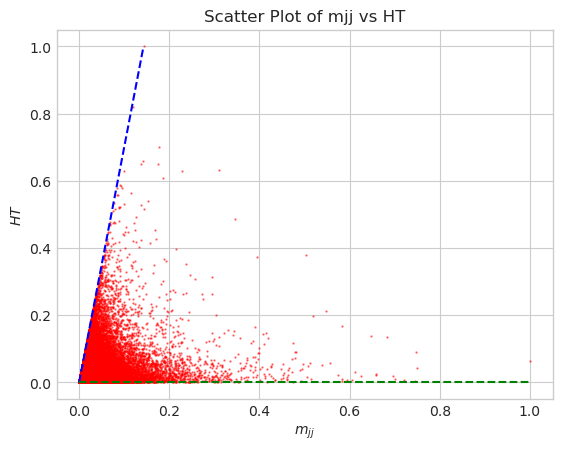

4231

In [5]:
# Scatter plot of the scaled samples

plt.scatter(mjj, HT, s=0.5, alpha=0.5, label='Data Points', color='red')
plt.xlabel(r"$m_{jj}$") # mjj
plt.ylabel(r"$HT$") # HT
plt.title("Scatter Plot of mjj vs HT")
slopev = 7.0
xlv = np.linspace(0, 1/slopev, 100)
ylv = slopev*xlv
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
slopeh = 0.0
xlh = np.linspace(0, 1, 100)
ylh = slopeh*xlh
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.show()
plt.close()
gc.collect()

In [6]:
mjj = mjj.reshape(-1, 1)
HT = HT.reshape(-1, 1)

In [ ]:
# Fit kernel density estimate on the scaled covariates
scaled_samples = np.hstack((mjj, HT))
d = scaled_samples.shape[1]
jxbins = 3000j
bw_adj_joint = DataConfig().bw_adj_joint
kernel_type = DataConfig().kernel_type
slices = [slice(-1.1, 1.1, jxbins), slice(-1.1, 1.1, jxbins)]
grids = np.mgrid[tuple(slices)]
grid_coords = np.vstack([[grids[i].ravel()] for i in range(d)]).T
bw = bw_adj_joint * scipy.stats.gaussian_kde(scaled_samples.T).scotts_factor()
kde_all = FFTKDE(bw=bw, kernel=kernel_type)
kde_all.fit(scaled_samples)
zgrid = kde_all.evaluate(grid_coords).reshape(grids[0].shape)
zgrid = np.clip(zgrid, 0, None)  # Ensure non-negative values

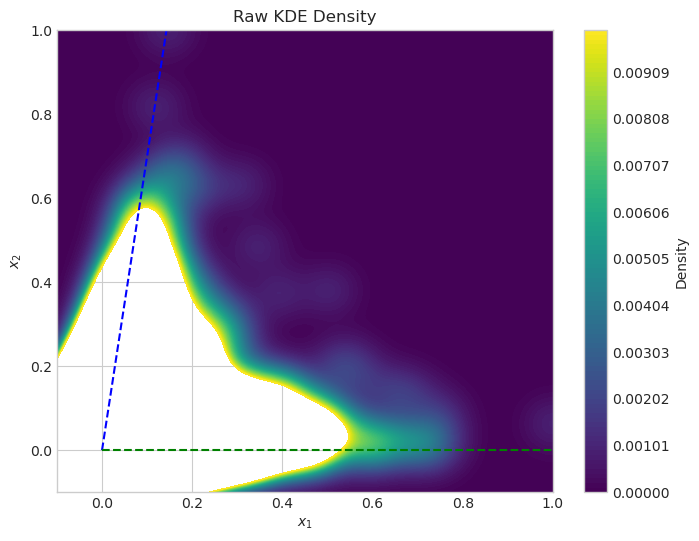

6239

In [8]:
# Raw kernel density estimate

plt.figure(figsize=(8, 6))
vmin, vmax = 0, 0.01
levels = np.linspace(vmin, vmax, 100)  # for 30 intervals
plt.contourf(grids[0], grids[1], zgrid, levels=levels, cmap="viridis")
plt.colorbar(label="Density")
plt.xlabel(r"$x_1$") # R
plt.ylabel(r"$x_2$") # mjj
plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)
plt.title(f"Raw KDE Density")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.show()
plt.close()
gc.collect()

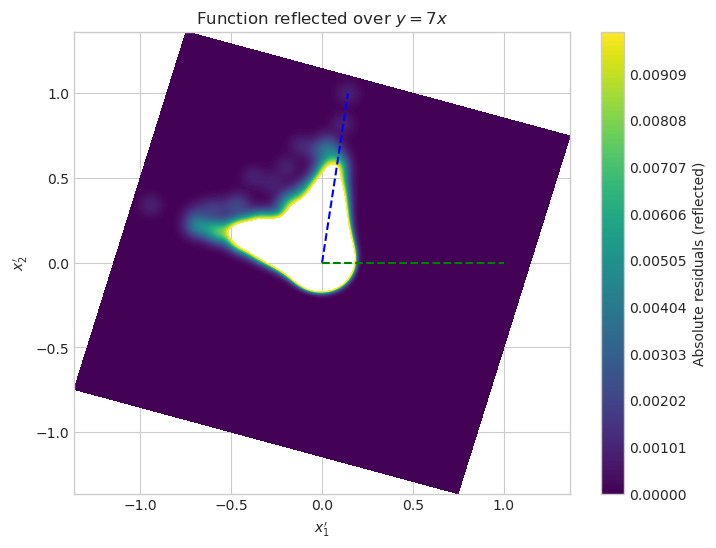

6756

In [9]:
# Reflection trick demo on a hard boundary

# Assume xgrid, ygrid are your meshgrid arrays, zgrid is your function
m = 7

# Flatten the grid for easier computation
x_flat = grids[0].ravel()
y_flat = grids[1].ravel()

# Compute the reflection over y = m*x
d = (x_flat + m * y_flat) / (1 + m**2)
x_ref = 2 * d - x_flat
y_ref = 2 * d * m - y_flat

# Reshape to grid shape
x_ref_grid = x_ref.reshape(grids[0].shape)
y_ref_grid = y_ref.reshape(grids[1].shape)
z_ref_grid = zgrid  # or zgrid if you want signed values

# Plot on the reflected grid
plt.figure(figsize=(8, 6))
plt.contourf(x_ref_grid, y_ref_grid, z_ref_grid, levels=levels, cmap="viridis")

plt.colorbar(label="Absolute residuals (reflected)")
plt.xlabel(r"$x_1'$")
plt.ylabel(r"$x_2'$")
plt.title("Function reflected over $y=7x$")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.show()
plt.close() 
gc.collect()

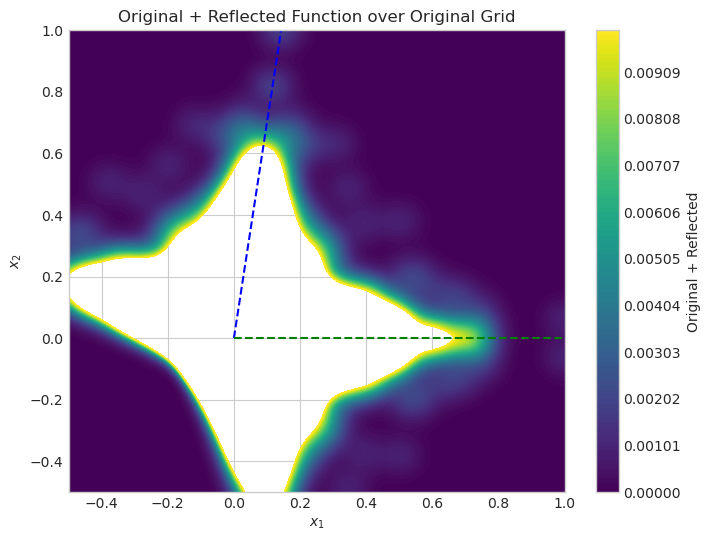

In [10]:
# Corrected KDE using reflection trick

m1 = 7
m2 = 0

# 1. Reflect the original grid points
x_flat1 = grids[0].ravel()
y_flat1 = grids[1].ravel()
d1 = (x_flat1 + m1 * y_flat1) / (1 + m1**2)
x_ref1 = 2 * d1 - x_flat1
y_ref1 = 2 * d1 * m1 - y_flat1

x_flat2 = grids[0].ravel()
y_flat2 = grids[1].ravel()
d2 = (x_flat2 + m2 * y_flat2) / (1 + m2**2)
x_ref2 = 2 * d2 - x_flat2
y_ref2 = 2 * d2 * m2 - y_flat2

# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp1 = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    np.abs(zgrid),            # function values
    bounds_error=False,
    fill_value=0
)

interp2 = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    np.abs(zgrid),            # function values
    bounds_error=False,
    fill_value=0
)


# For each original grid point, get the value of the reflected functions at that location
reflected_vals1 = interp1(np.vstack([x_ref1, y_ref1]).T)
reflected_vals_grid1 = reflected_vals1.reshape(grids[0].shape)

reflected_vals2 = interp2(np.vstack([x_ref2, y_ref2]).T)
reflected_vals_grid2 = reflected_vals2.reshape(grids[0].shape)

# 3. Add the reflected function to the original function
sum_grid = reflected_vals_grid1 + reflected_vals_grid2 + zgrid

# 4. Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(grids[0], grids[1], sum_grid, levels=levels, cmap="viridis")
plt.colorbar(label="Original + Reflected")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Original + Reflected Function over Original Grid")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)
plt.show()

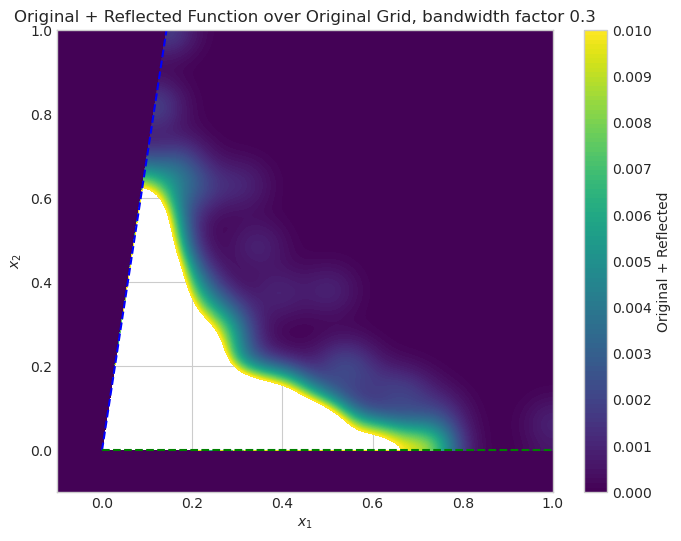

Likelihood score of the corrected KDE: 470,145.69121189753


In [11]:
mask = (grids[1] > 7 * grids[0]) | (grids[1] < 0)
sum_grid[mask] = 0
# 4. Plot the result
plt.figure(figsize=(8, 6))
plt.contourf(grids[0], grids[1], sum_grid, levels=levels, cmap="viridis")
plt.colorbar(label="Original + Reflected", ticks=np.linspace(vmin, vmax, 11))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(f"Original + Reflected Function over Original Grid, bandwidth factor {bw_adj_joint}")
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)
plt.show()

# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp_kde_at_samples = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    sum_grid,            # function values
    bounds_error=False,
    fill_value=0
)


# For each original grid point, get the value of the reflected functions at that location
kde_eval_at_samples = interp_kde_at_samples(scaled_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}")

In [12]:
import numpy as np

# Flatten the grids and sum_grid
x_flat = grids[0].ravel()
y_flat = grids[1].ravel()
sum_flat = sum_grid.ravel()
mask_flat = mask.ravel()

# Select unmasked points
x_unmasked = x_flat[~mask_flat]
y_unmasked = y_flat[~mask_flat]
sum_unmasked = sum_flat[~mask_flat]

# Stack into columns and save as CSV
data = np.column_stack((x_unmasked, y_unmasked, sum_unmasked))

# Results

In [13]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

In [14]:
raw_equations = [
    '2.090535006288719',
    'exp(0.7374616095597221)',
    '0.8414644345688691 / x1',
    'pow3(0.9440285301708932) / x1',
    '2.840959135159774 / (x2 + x1)',
    'x2 / pow3(x1 + x2)',
    'exp((x1 + x2) / -0.05459454825770353) / 0.0028244764711741585',
    '0.034146235305494675 / ((pow3(x1) + pow3(x2)) + 0.00017986124388753264)',
    'exp(((0.7085044694804051 * x2) + x1) / -0.04486907643689514) / 0.0025534302366485035',
    '0.025243124435902566 / ((0.00013209544393223165 + pow3(-0.015526904559981592 + x2)) + pow3(x1))',
    '0.06021343996074825 / ((pow3(x2) + 0.00032443090344524473) * exp(pow2(x1) / 0.005263042819159475))',
    '0.654012936959842 / (0.0034996534947936537 * exp((pow2(x1) / 0.005315022686226753) + pow2(x2 / 0.08408622440214643)))',
    '(0.07262867756736505 - pow2(x2)) / (exp(pow2(x1) / 0.005263463317900096) * (0.0003928453113340877 + pow3(x2)))',
    '0.08408622440214643 / (exp((pow2(x1) / 0.005263042819159475) + pow2(x2 / -0.194019234670927)) * (pow3(x2) + 0.0004543466750722736))',
    '0.06376428404735136 / ((pow2(pow3(x2 / 0.16150960469721556)) + exp(pow2(x1) / 0.0052488969485840475)) * (pow3(x2) + 0.00034517857235624066))',
    '0.07419219887331074 / ((0.0004561132944133364 + pow3(x2)) * (exp((pow2(x1) / 0.005617224857471601) + pow2(x2 / 0.200964734238503)) + -0.1361224547445641))',
    '0.07203701351284848 / ((pow3(x2) + 0.00046087651498753323) * (pow3(-0.5566378221507172) + exp(pow2(x2 / -0.2013624629509566) + (pow2(x1) / 0.005751034162213533))))',
    '0.06367971666681055 + (0.07419219887331074 / ((exp((pow2(x1) / 0.005617224857471601) + pow2(x2 / 0.200964734238503)) + -0.1361224547445641) * (0.0004561132944133364 + pow3(x2))))',
    '0.05758174463092609 + (0.07203701351284848 / ((pow3(x2) + 0.00046087651498753323) * (pow3(-0.5566378221507172) + exp(pow2(x2 / 0.2006343125611199) + (pow2(x1) / 0.005751034162213533)))))',
    '(0.09001976270401611 + pow3(pow2(x1 / -0.24061571858445624))) / ((pow3(x2) + 0.000483117684768911) * exp(pow2(x2 / -0.17941983867120173) + (pow2(x1) / 0.005133235121843175)))',
    '(pow3(pow2(x1 / -0.24529100698662837)) + 0.06411247852279982) / ((pow3(x2) + 0.0003437415863096075) * (exp(pow2(x1) / 0.005067550788060732) + pow2(pow3(x2 / 0.1613856154279212))))',
    '(0.06402297176161158 + pow3(pow2((x1 / 0.16814923380619481) + -0.2741250328878744))) / ((pow3(x2) + 0.0003451298003517172) * (pow3(pow2(x2 / -0.16114400960972727)) + exp(pow2(x1) / 0.005169960005298225)))',
    '(0.06402297176161158 + pow3(pow2(-0.2741250328878744 + (x1 / exp(-1.7892018571863806))))) / ((0.0003451298003517172 + pow3(x2)) * (pow3(pow2(x2 / -0.16114400960972727)) + exp(pow2(x1) / 0.005169960005298225)))',
    '0.03984107617083789 + ((pow2(pow3(-0.2741250328878744 + (x1 / 0.16814923380619481))) + 0.06402297176161158) / ((pow3(pow2(x2 / -0.1604627025241577)) + exp(pow2(x1) / 0.005169960005298225)) * (pow3(x2) + 0.0003451298003517172)))',
    '(0.062259309425020865 / (exp(pow2(x1) / 0.0050865798262097915) * (0.0003432843044236077 + (pow3(pow2(x2 / (x2 - 0.5413048264599588))) + pow3(x2))))) + pow3(pow2((1.318898210574647 - x2) - (x1 / 0.5775031264653955)))',
]

complexity = [
    1,
    2,
    3,
    4,
    5,
    6,
    8,
    9,
    10,
    11,
    12,
    14,
    15,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    26,
    27,
    28,
    30,
]

loss = [
    139.89110216947827,
    139.8911021351579,
    97.87324488958323,
    97.87324355759247,
    76.60657299183167,
    25.594180482512616,
    7.710081871939173,
    5.4732154327994245,
    4.945557467076734,
    3.0968633917966937,
    0.2559299903074121,
    0.1507659377328147,
    0.1025598459734472,
    0.0757547282709271,
    0.0674897511083989,
    0.0615308568296317,
    0.0607259906569149,
    0.0577088946260681,
    0.057481332178869,
    0.0491529411233546,
    0.0366497351900575,
    0.0293456612114258,
    0.0292464971883751,
    0.0278094447456015,
    0.0263645732003249,
]


Original at complexity 1: 2.090535006288719
function_ready: 2.090535006288719
Processed: 2.10000000000000
LaTeX: 2.1

Original at complexity 2: exp(0.7374616095597221)
function_ready: np.exp(0.7374616095597221)
Processed: 2.10000000000000
LaTeX: 2.1

Original at complexity 3: 0.8414644345688691 / x1
function_ready: 0.8414644345688691 / x1
Processed: 0.84/x1
LaTeX: \frac{0.84}{m_{jj}}

Original at complexity 4: pow3(0.9440285301708932) / x1
function_ready: pow3(0.9440285301708932) / x1
Processed: pow3(0.94)/x1
LaTeX: \frac{0.83}{m_{jj}}

Original at complexity 5: 2.840959135159774 / (x2 + x1)
function_ready: 2.840959135159774 / (x2 + x1)
Processed: 2.8/(x1 + x2)
LaTeX: \frac{2.8}{HT + m_{jj}}

Original at complexity 6: x2 / pow3(x1 + x2)
function_ready: x2 / pow3(x1 + x2)
Processed: x2/pow3(x1 + x2)
LaTeX: \frac{HT}{\left(HT + m_{jj}\right)^{3}}

Original at complexity 8: exp((x1 + x2) / -0.05459454825770353) / 0.0028244764711741585
function_ready: np.exp((x1 + x2) / -0.0545945482577035

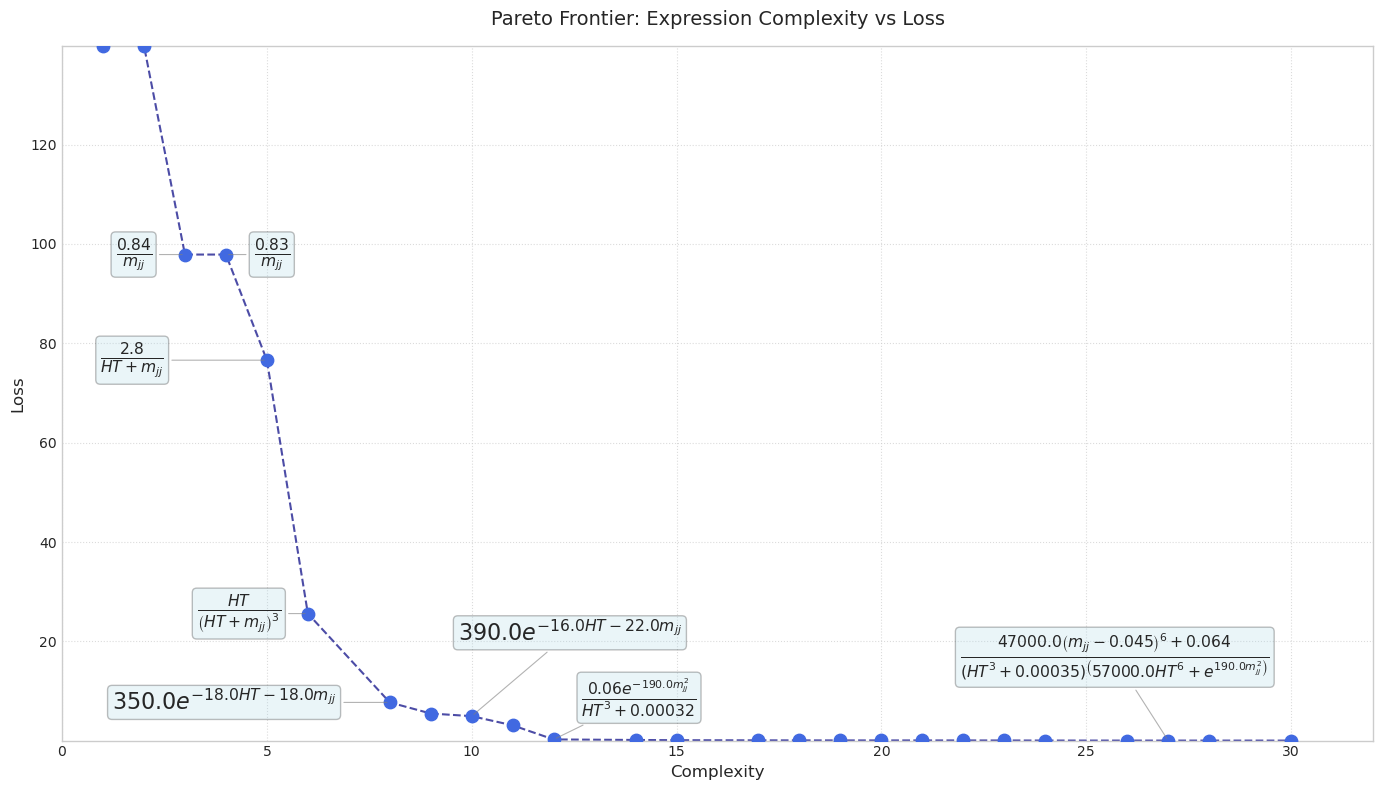

In [15]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2 = sp.symbols('x1 x2')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = mt.subs({x1: sp.Symbol('m_{jj}'), x2: sp.Symbol('HT')})
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (-50, 0), (20, 0), (-120, 0),
    (-80, 0), (-200, 0), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-150, 60), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [3-1, 4-1, 5-1, 6-1, 7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Residuals

In [16]:
level_min = 0
level_max = 200
level_min_delta = -20
level_max_delta = 20

In [17]:
predicted_functions = [eval(f'lambda x1, x2: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]
masked_functions = [
    (lambda f: lambda x1, x2, mask: np.where(mask, f(x1, x2), 0))(f)
    for f in predicted_functions
]

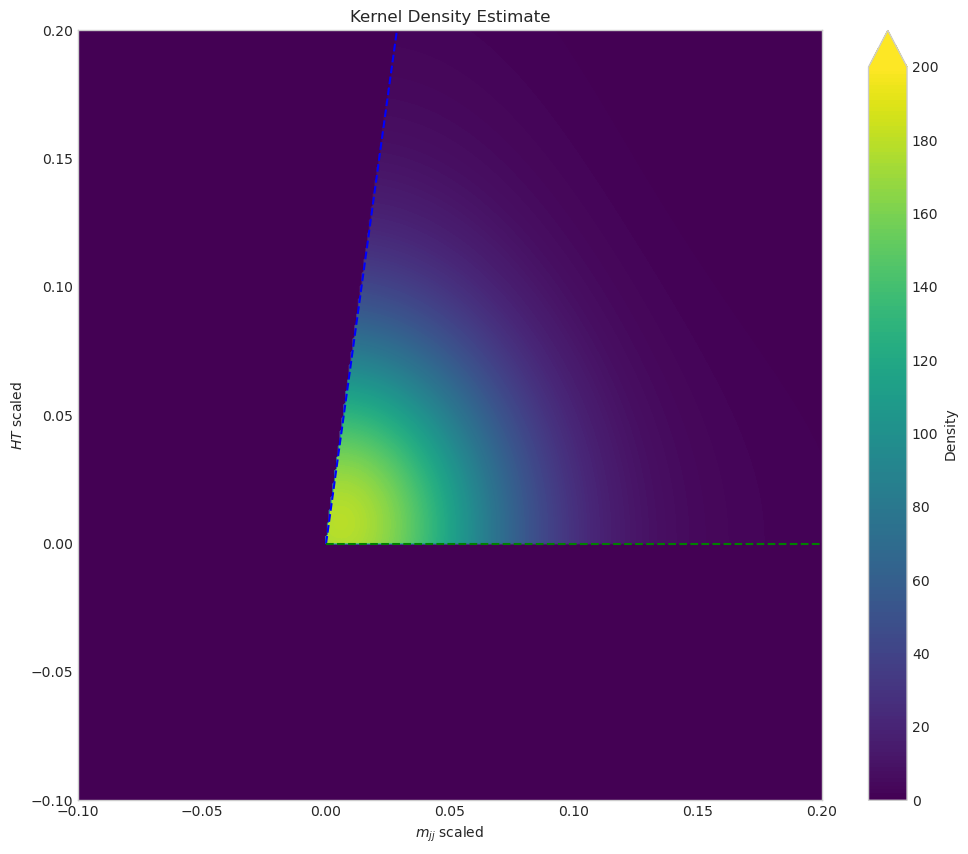

In [18]:
# 4. Plot the result
plt.figure(figsize=(12, 10))
plt.contourf(grids[0], grids[1], sum_grid, levels=np.linspace(level_min, level_max, 200), cmap="viridis", extend='max')
plt.colorbar(label="Density", ticks=np.linspace(level_min, level_max, 11))
plt.xlabel(r"$m_{jj}$ scaled")
plt.ylabel(r"$HT$ scaled")
plt.title("Kernel Density Estimate") 
plt.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
plt.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)
plt.show()

In [19]:
# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp_kde_at_samples = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    sum_grid,            # function values
    bounds_error=False,
    fill_value=0
)


# For each original grid point, get the value of the reflected functions at that location
kde_eval_at_samples = interp_kde_at_samples(scaled_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}")

Likelihood score of the corrected KDE: 470,145.69121189753


In [20]:
print(f"min kde: {np.min(sum_grid)}, max kde: {np.max(sum_grid)}")

min kde: 0.0, max kde: 178.17034011090493


# Likelihood Evaluation

In [21]:
kde_eval_at_samples = interp_kde_at_samples(scaled_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}\n")

for idx, func in enumerate(masked_functions):
    # Compute likelihood scores
    prediction_eval_at_samples = func(scaled_samples[:, 0], scaled_samples[:, 1], np.ones_like(scaled_samples[:,0], dtype=bool))
    likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples + 1e-12))  # add small value to avoid log(0)
    print(f"Function at complexity {complexity[idx]}: Likelihood score = {likelihood_score_pred:,}")

Likelihood score of the corrected KDE: 470,145.69121189753

Function at complexity 1: Likelihood score = 73,742.00170891179
Function at complexity 2: Likelihood score = 73,746.16095602006
Function at complexity 3: Likelihood score = inf
Function at complexity 4: Likelihood score = inf
Function at complexity 5: Likelihood score = 455,983.3143897275
Function at complexity 6: Likelihood score = 628,709.8602607984
Function at complexity 8: Likelihood score = 496,952.5682805473
Function at complexity 9: Likelihood score = 479,322.57844416774
Function at complexity 10: Likelihood score = 506,216.754664985
Function at complexity 11: Likelihood score = 484,340.17001843936
Function at complexity 12: Likelihood score = 473,103.0718205422
Function at complexity 14: Likelihood score = 465,406.1457561309
Function at complexity 15: Likelihood score = nan
Function at complexity 17: Likelihood score = 470,869.2996140801
Function at complexity 18: Likelihood score = 470,719.61722662934
Function at comp

<string>:1: RuntimeWarning: divide by zero encountered in divide
<string>:1: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_2942/1696207567.py:8: RuntimeWarning: invalid value encountered in log
  likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples + 1e-12))  # add small value to avoid log(0)


# Plots

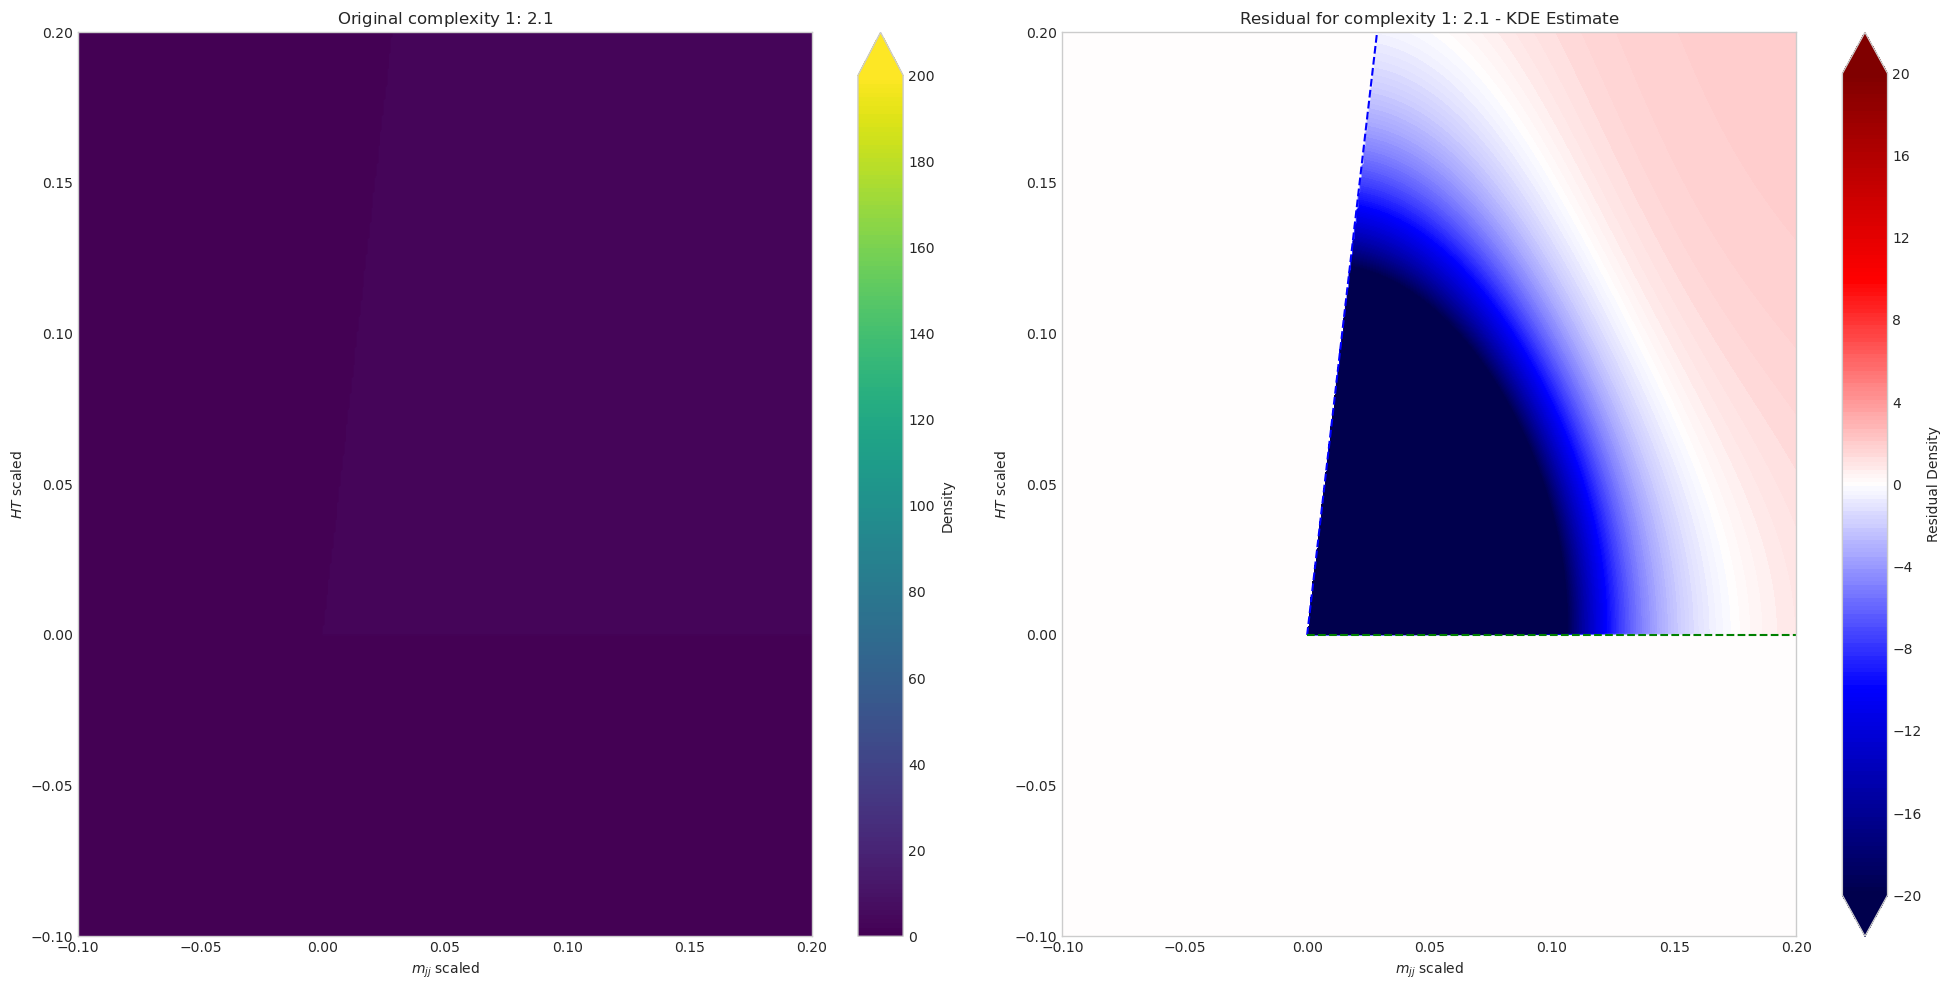

Complexity 1: Likelihood score: 73,742.00170886397
complexity 1 :: min predict: 0.00, max predict: 2.09
complexity 1 :: min residual: -176.08, max residual: 2.09


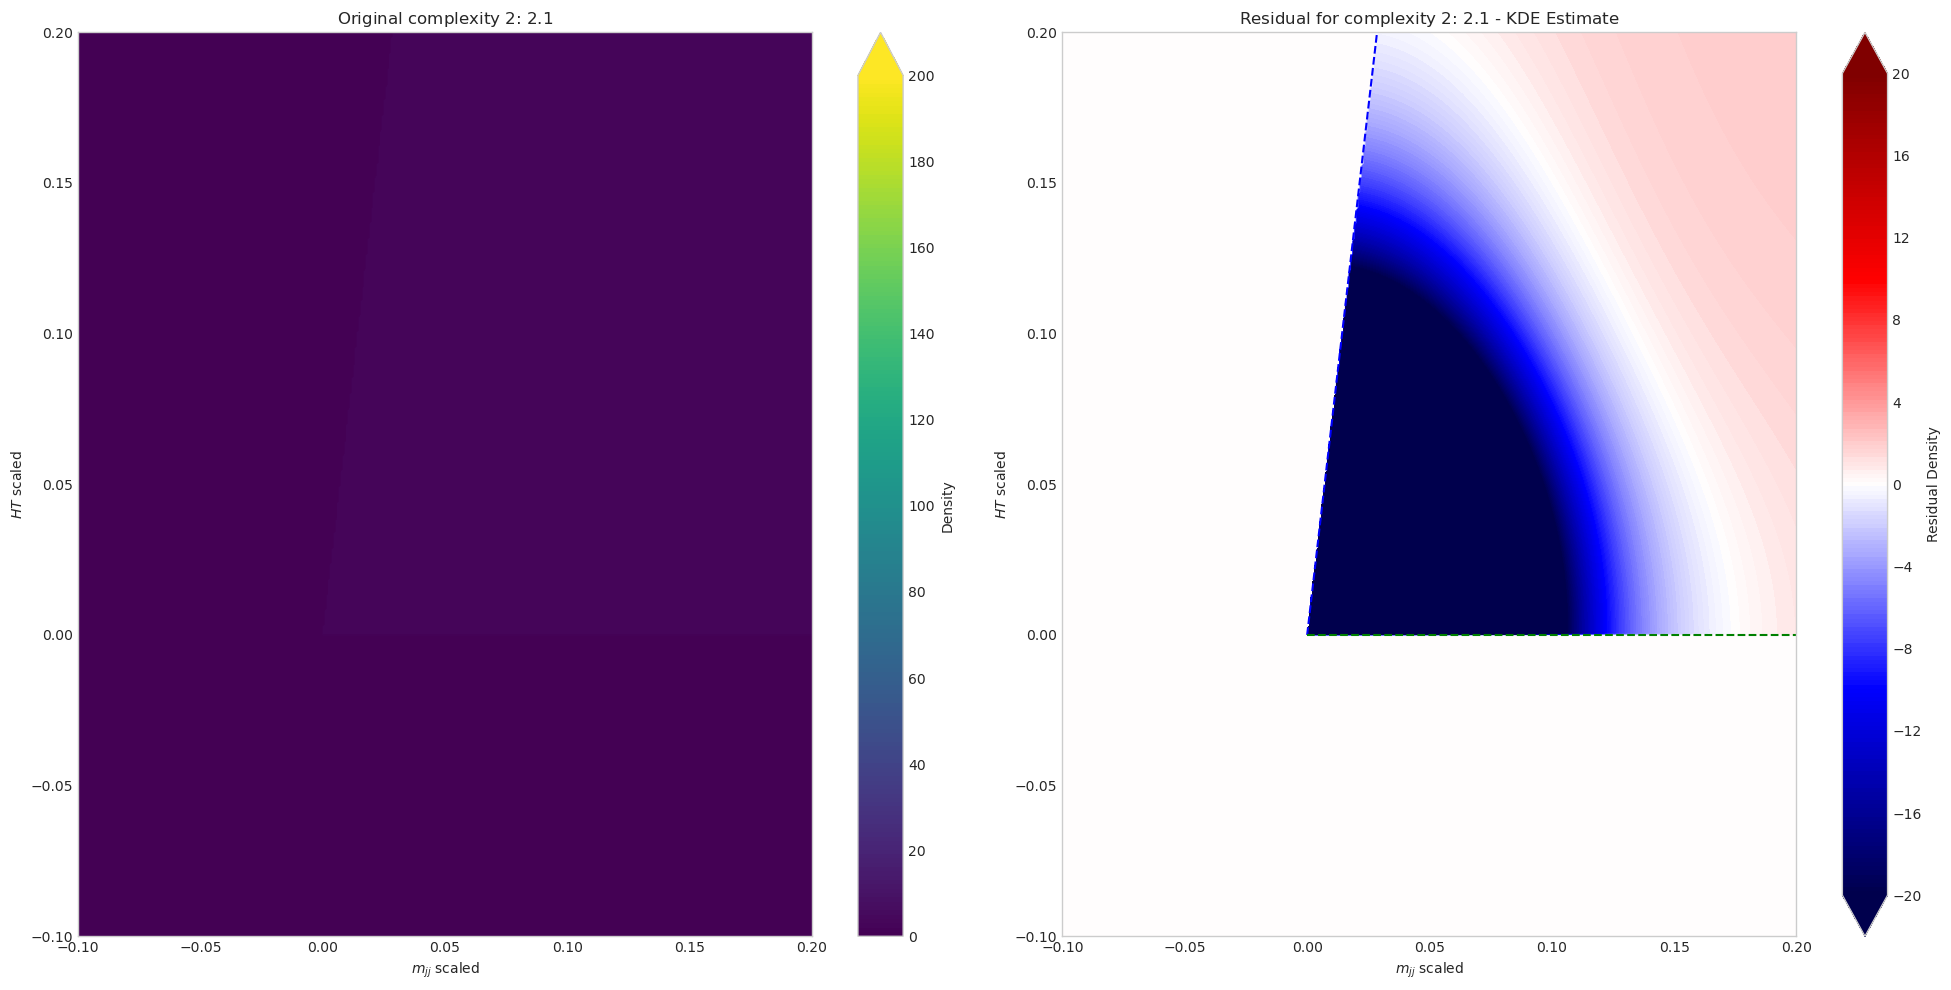

Complexity 2: Likelihood score: 73,746.16095597217
complexity 2 :: min predict: 0.00, max predict: 2.09
complexity 2 :: min residual: -176.08, max residual: 2.09


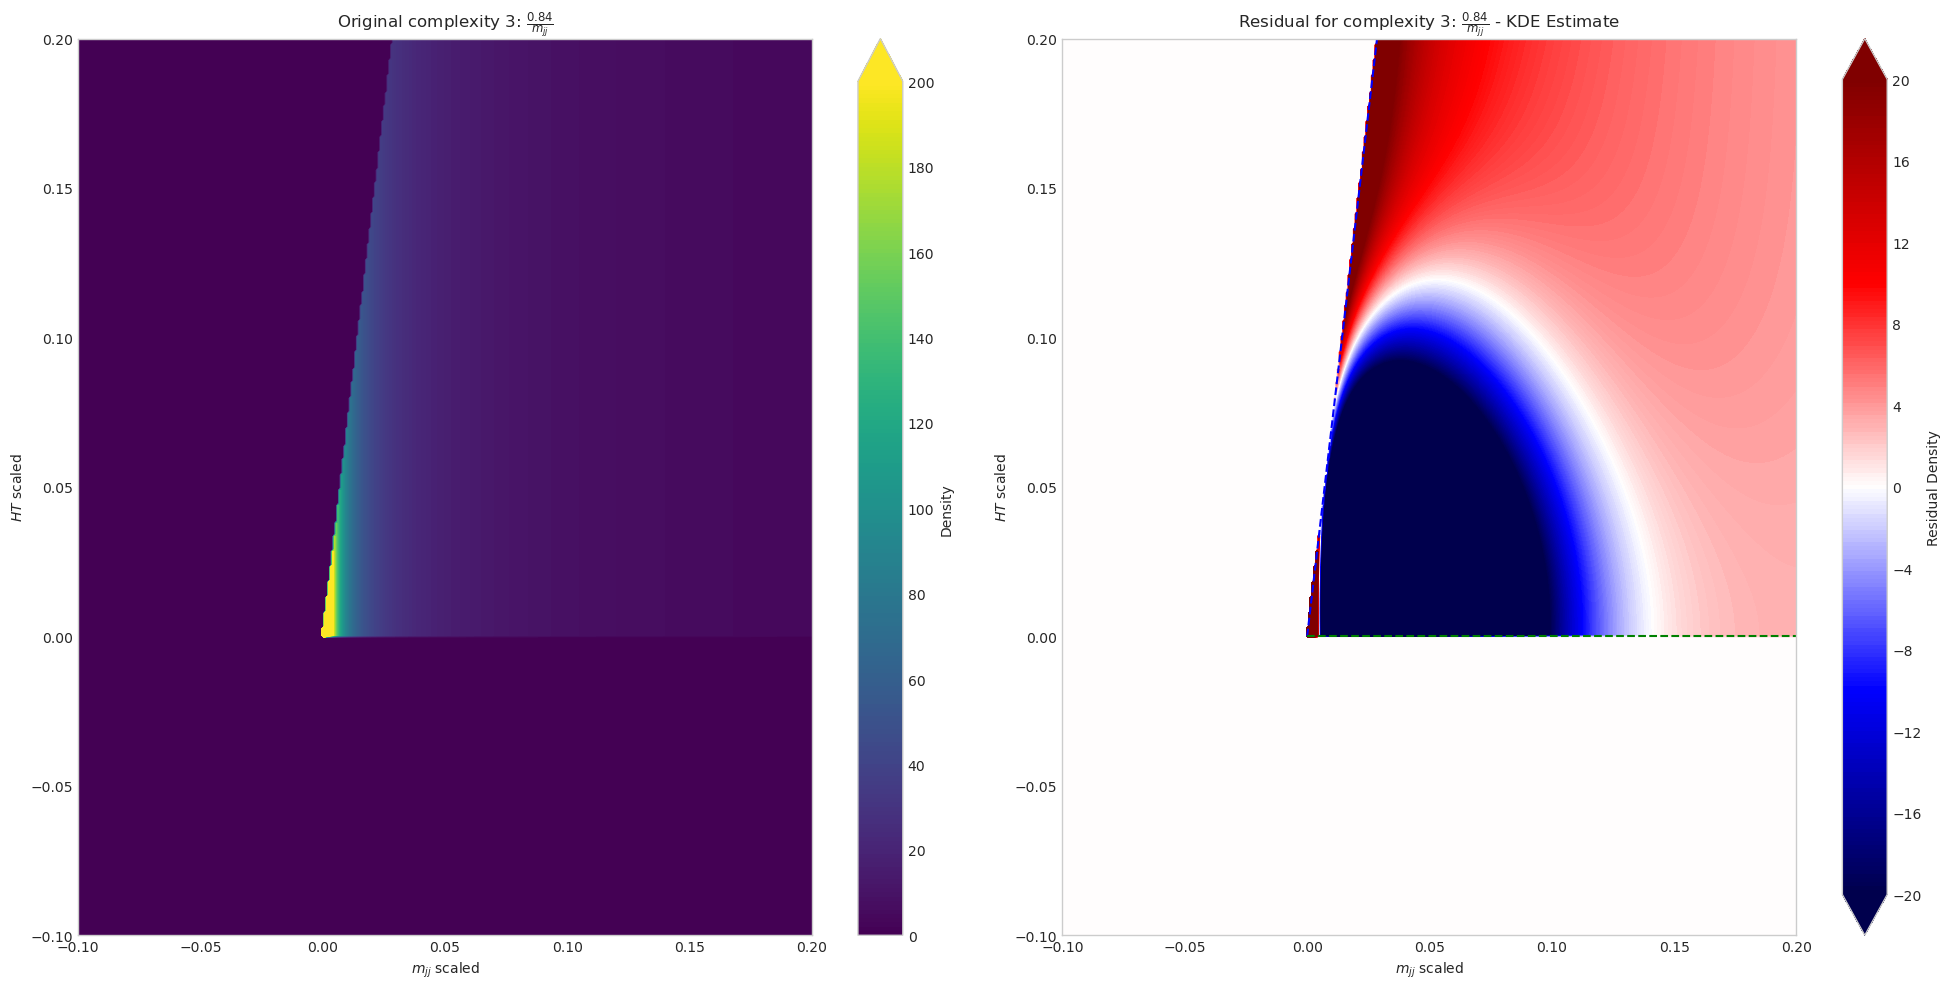

Complexity 3: Likelihood score: inf
complexity 3 :: min predict: 0.00, max predict: 2294.14
complexity 3 :: min residual: -130.40, max residual: 2119.47


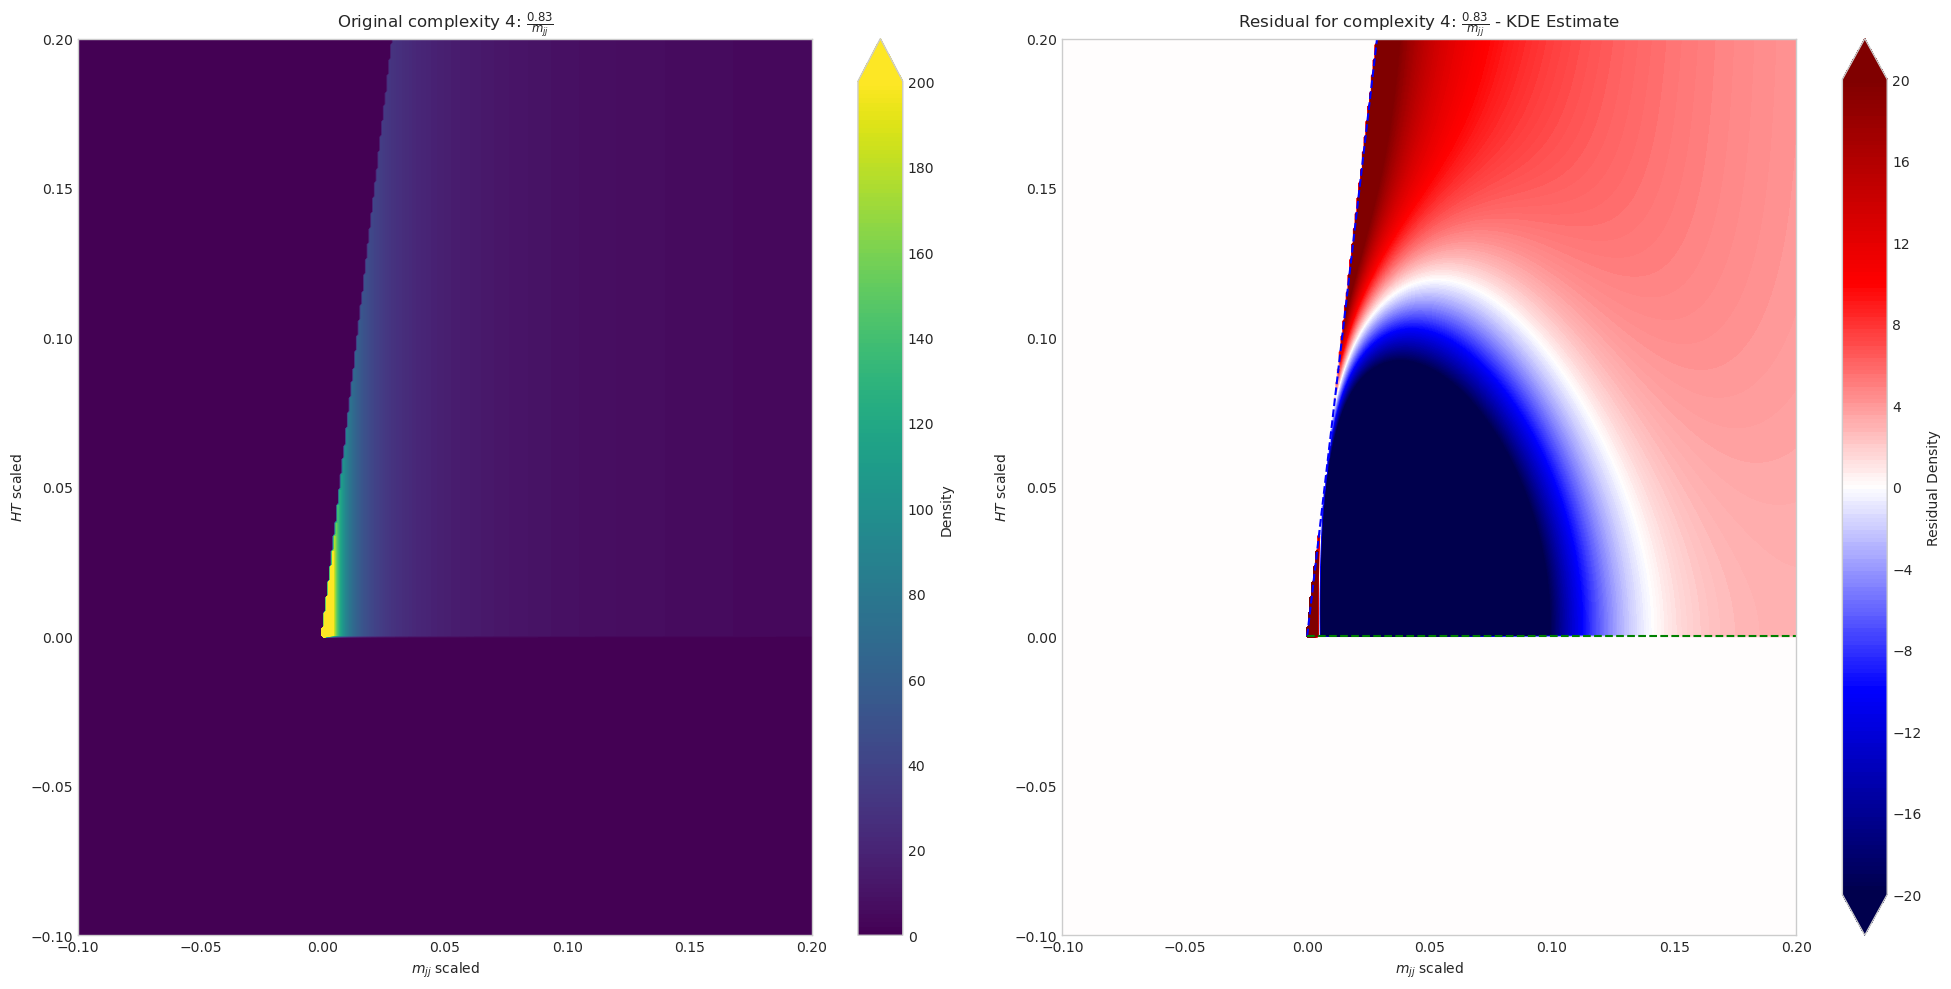

Complexity 4: Likelihood score: inf
complexity 4 :: min predict: 0.00, max predict: 2293.71
complexity 4 :: min residual: -130.41, max residual: 2119.05


<string>:1: RuntimeWarning: divide by zero encountered in divide


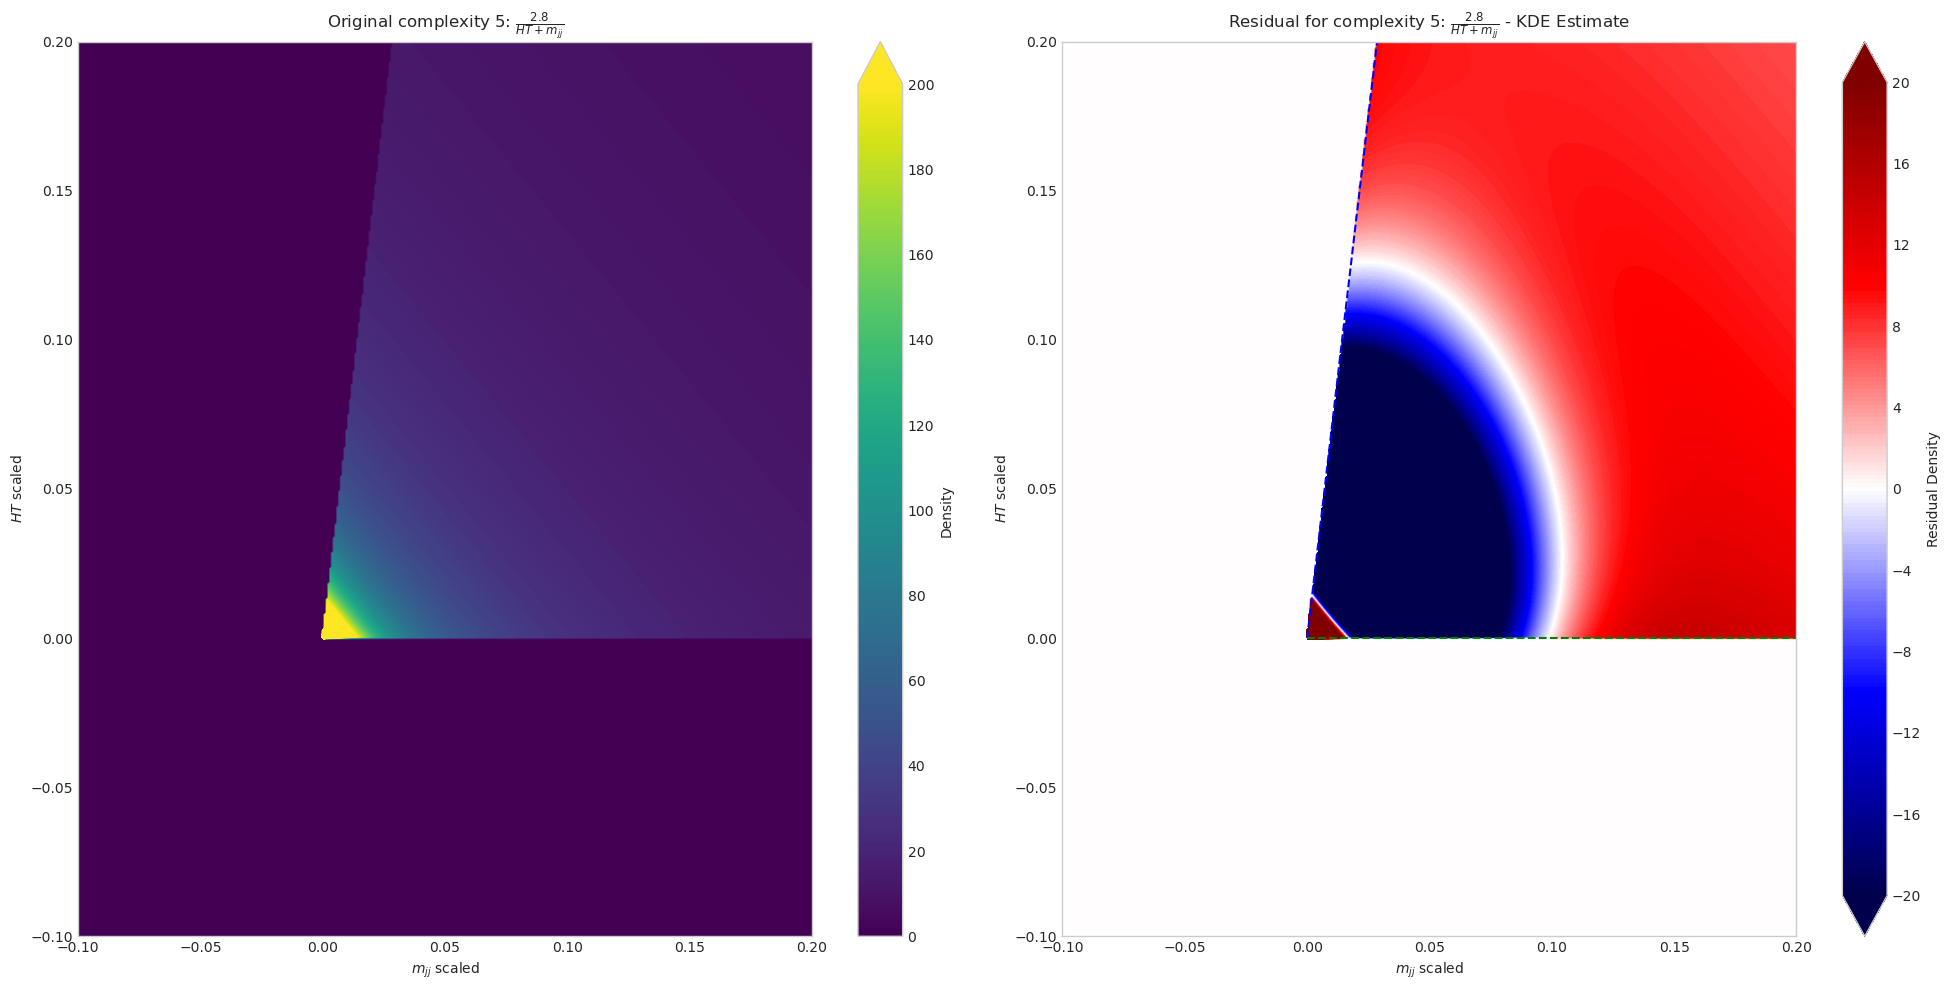

Complexity 5: Likelihood score: 455,983.31438972586
complexity 5 :: min predict: 0.00, max predict: 3872.74
complexity 5 :: min residual: -98.86, max residual: 3698.08


<string>:1: RuntimeWarning: divide by zero encountered in divide


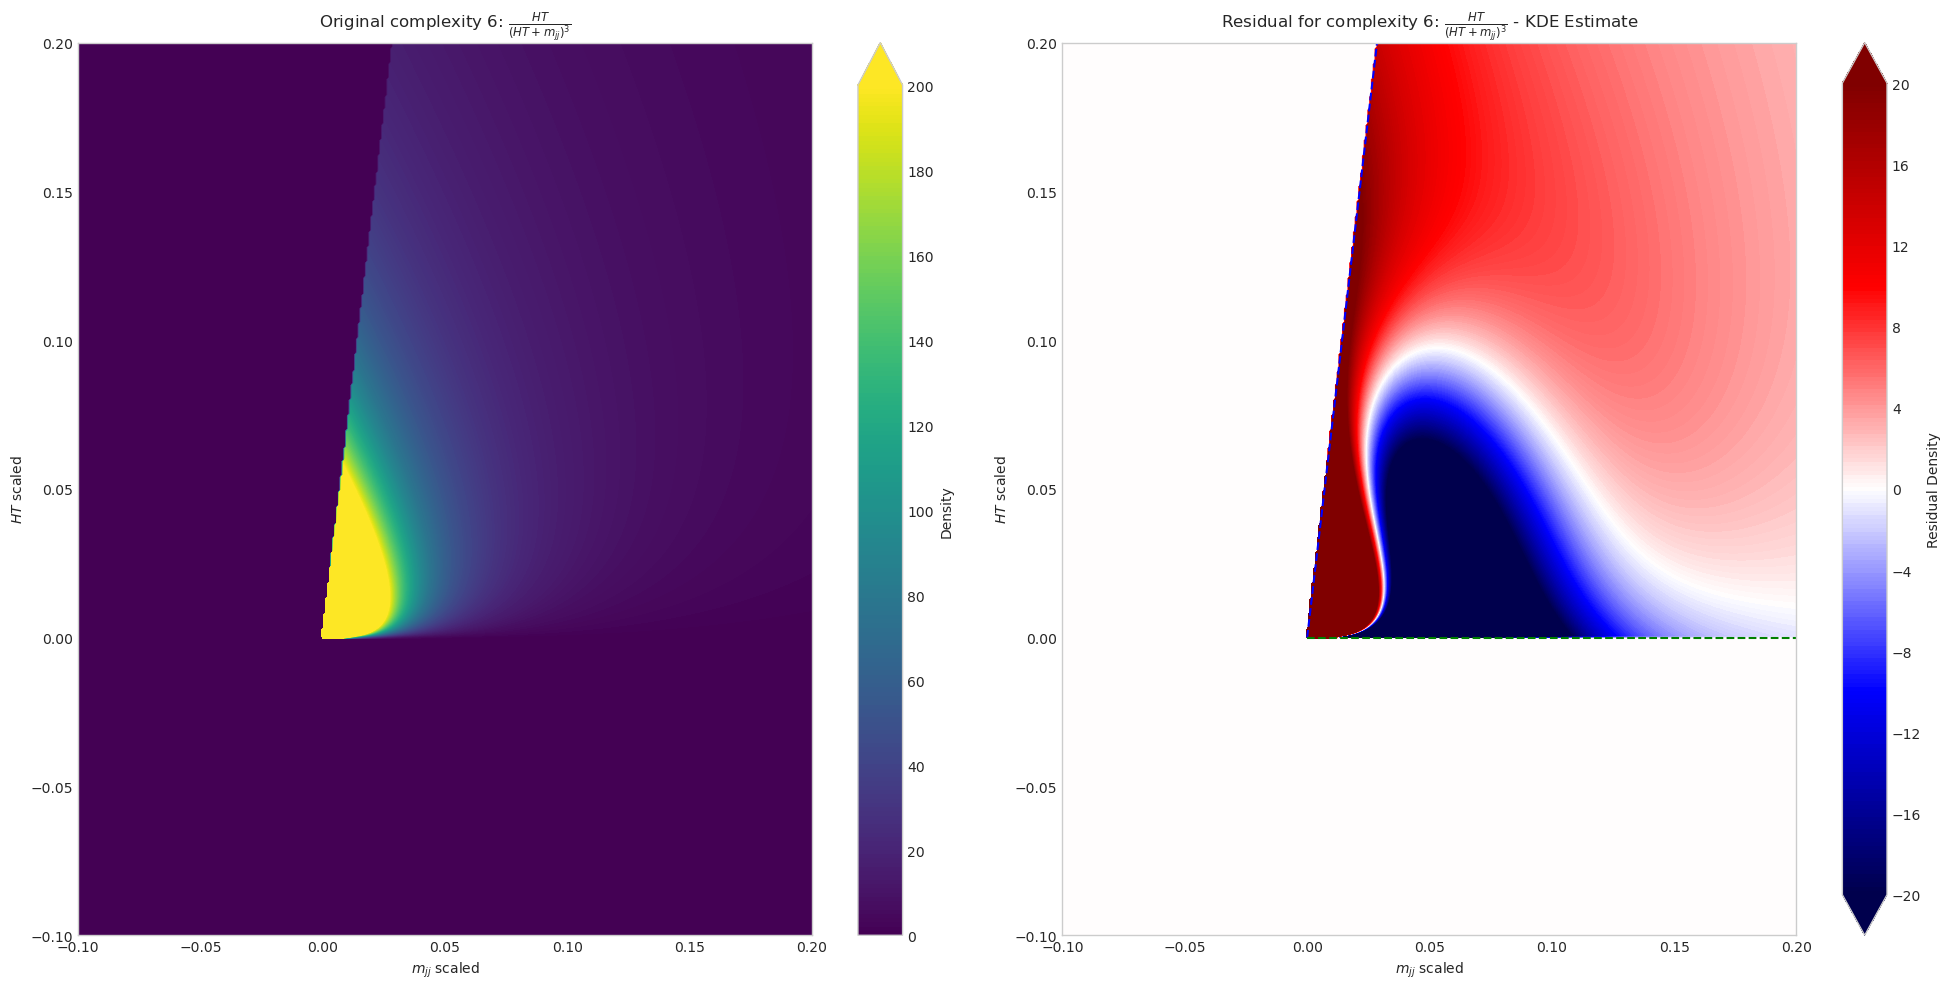

/tmp/ipykernel_2942/1043867983.py:76: RuntimeWarning: divide by zero encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples))


Complexity 6: Likelihood score: -inf
complexity 6 :: min predict: 0.00, max predict: 929132.33
complexity 6 :: min residual: -142.06, max residual: 928957.67


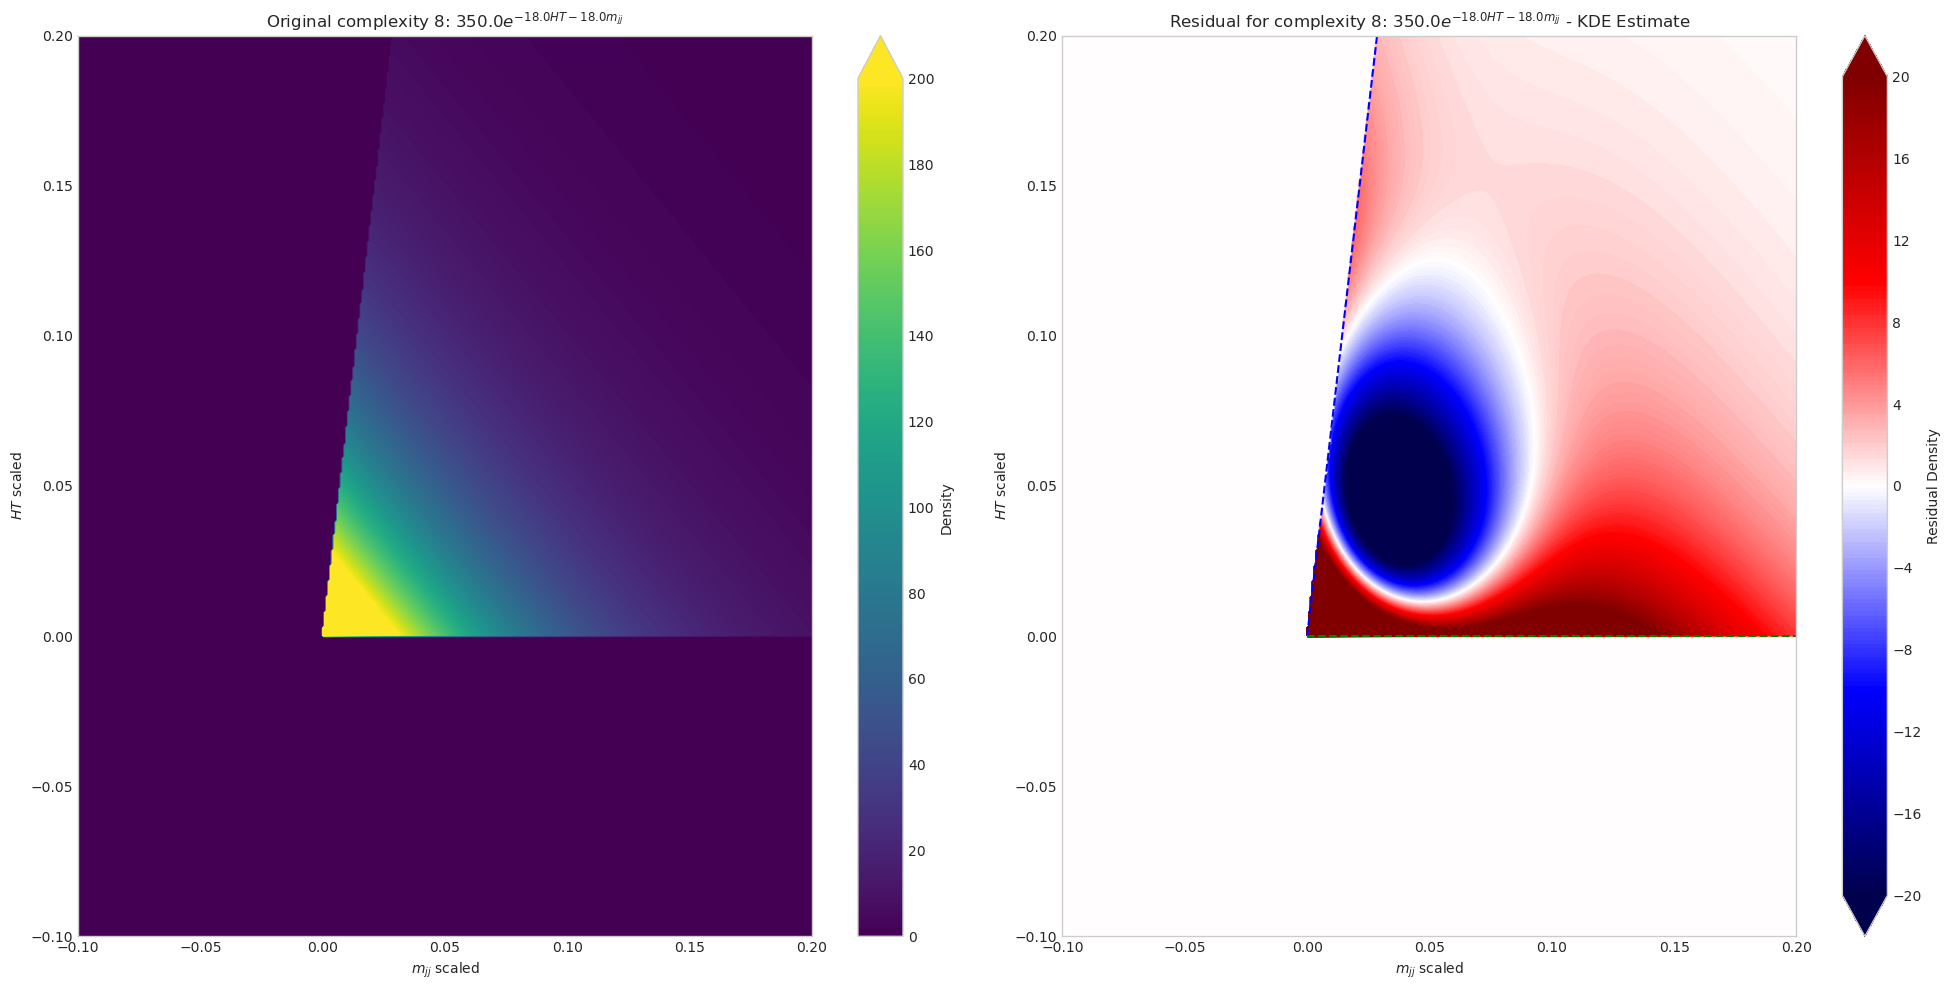

Complexity 8: Likelihood score: 496,952.5682757974
complexity 8 :: min predict: 0.00, max predict: 349.32
complexity 8 :: min residual: -31.98, max residual: 174.66


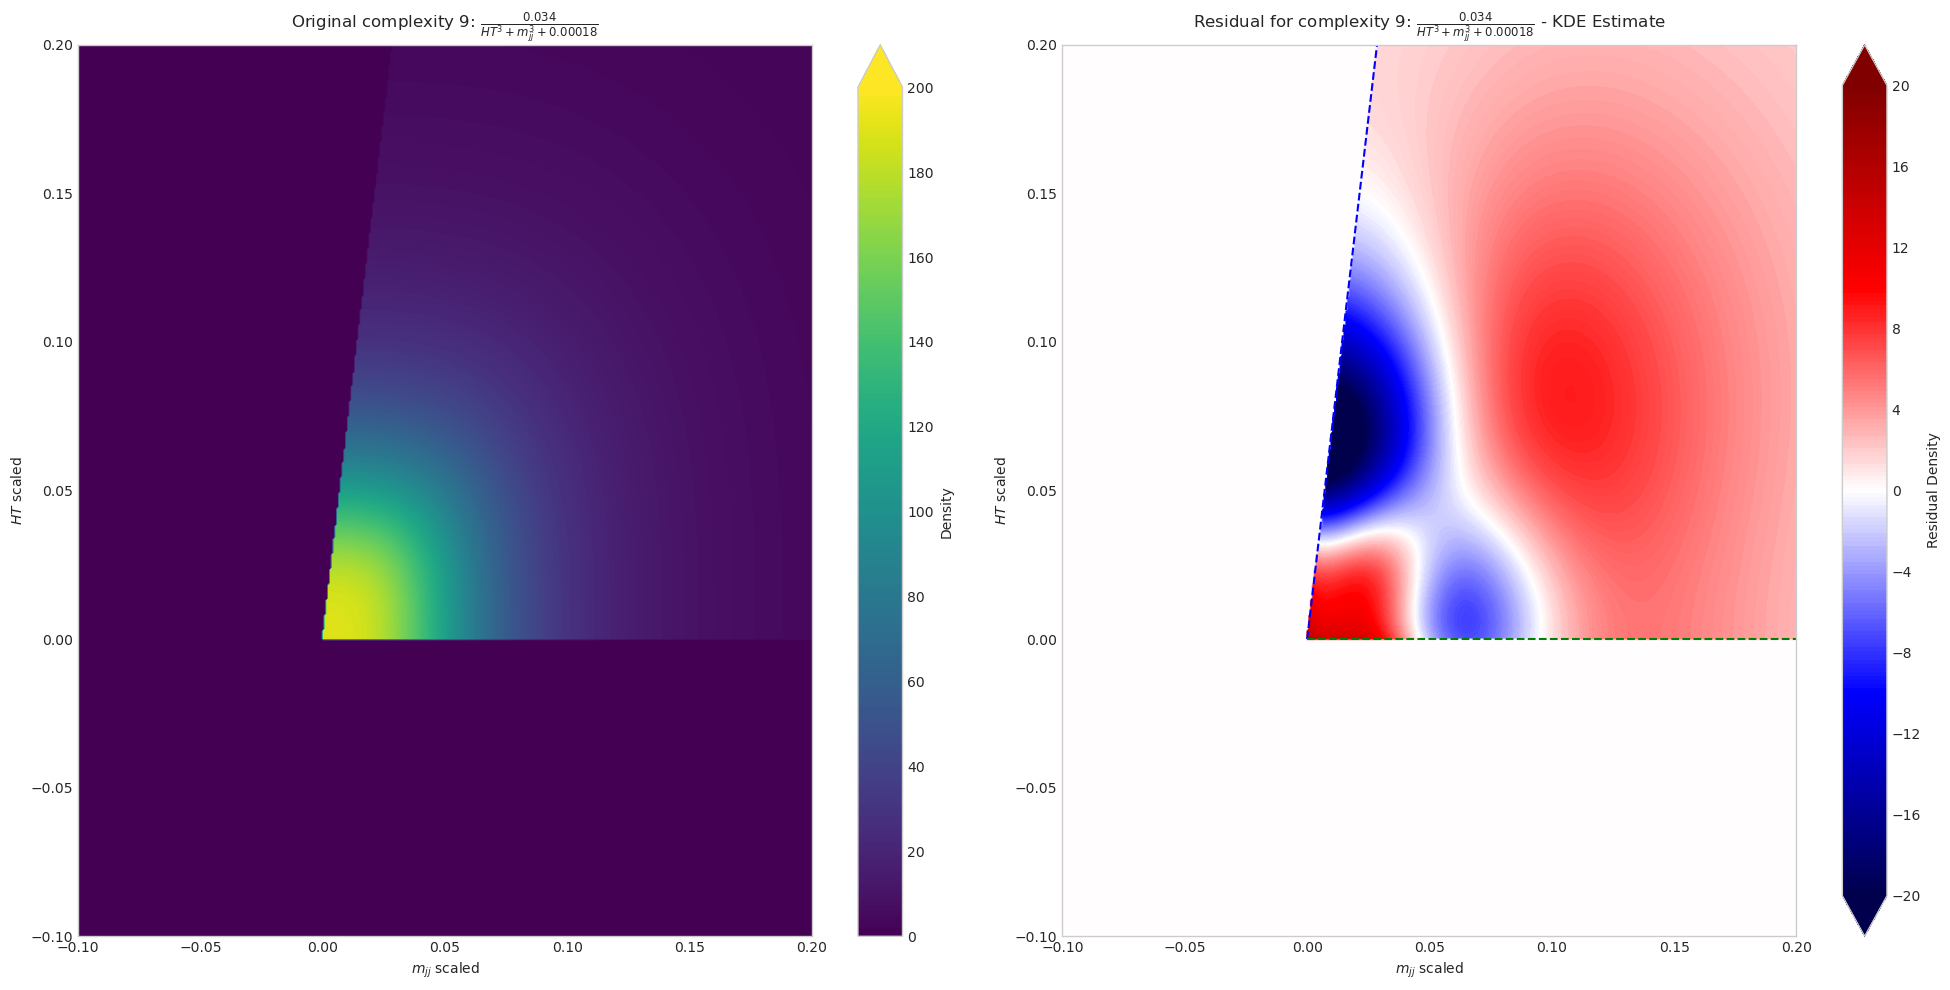

Complexity 9: Likelihood score: 479,322.57844416524
complexity 9 :: min predict: 0.00, max predict: 189.85
complexity 9 :: min residual: -24.59, max residual: 15.18


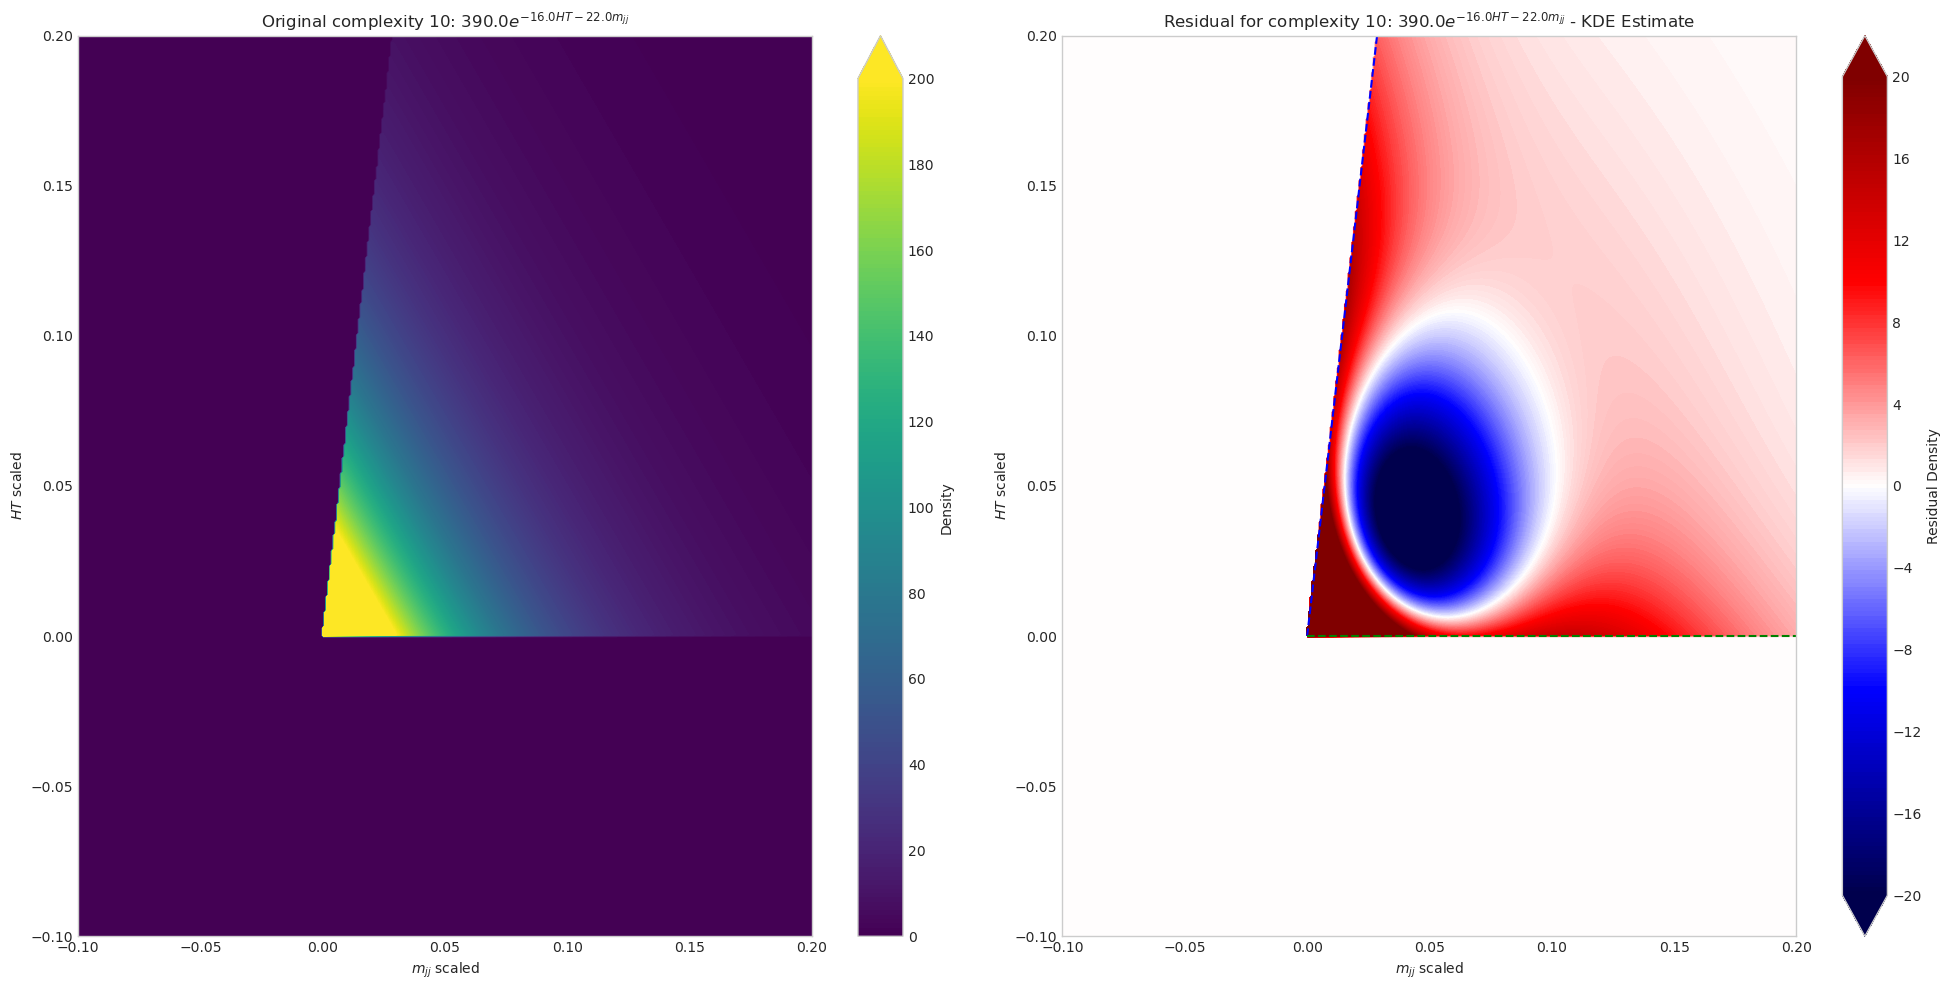

Complexity 10: Likelihood score: 506,216.75463078765
complexity 10 :: min predict: 0.00, max predict: 386.20
complexity 10 :: min residual: -27.53, max residual: 211.53


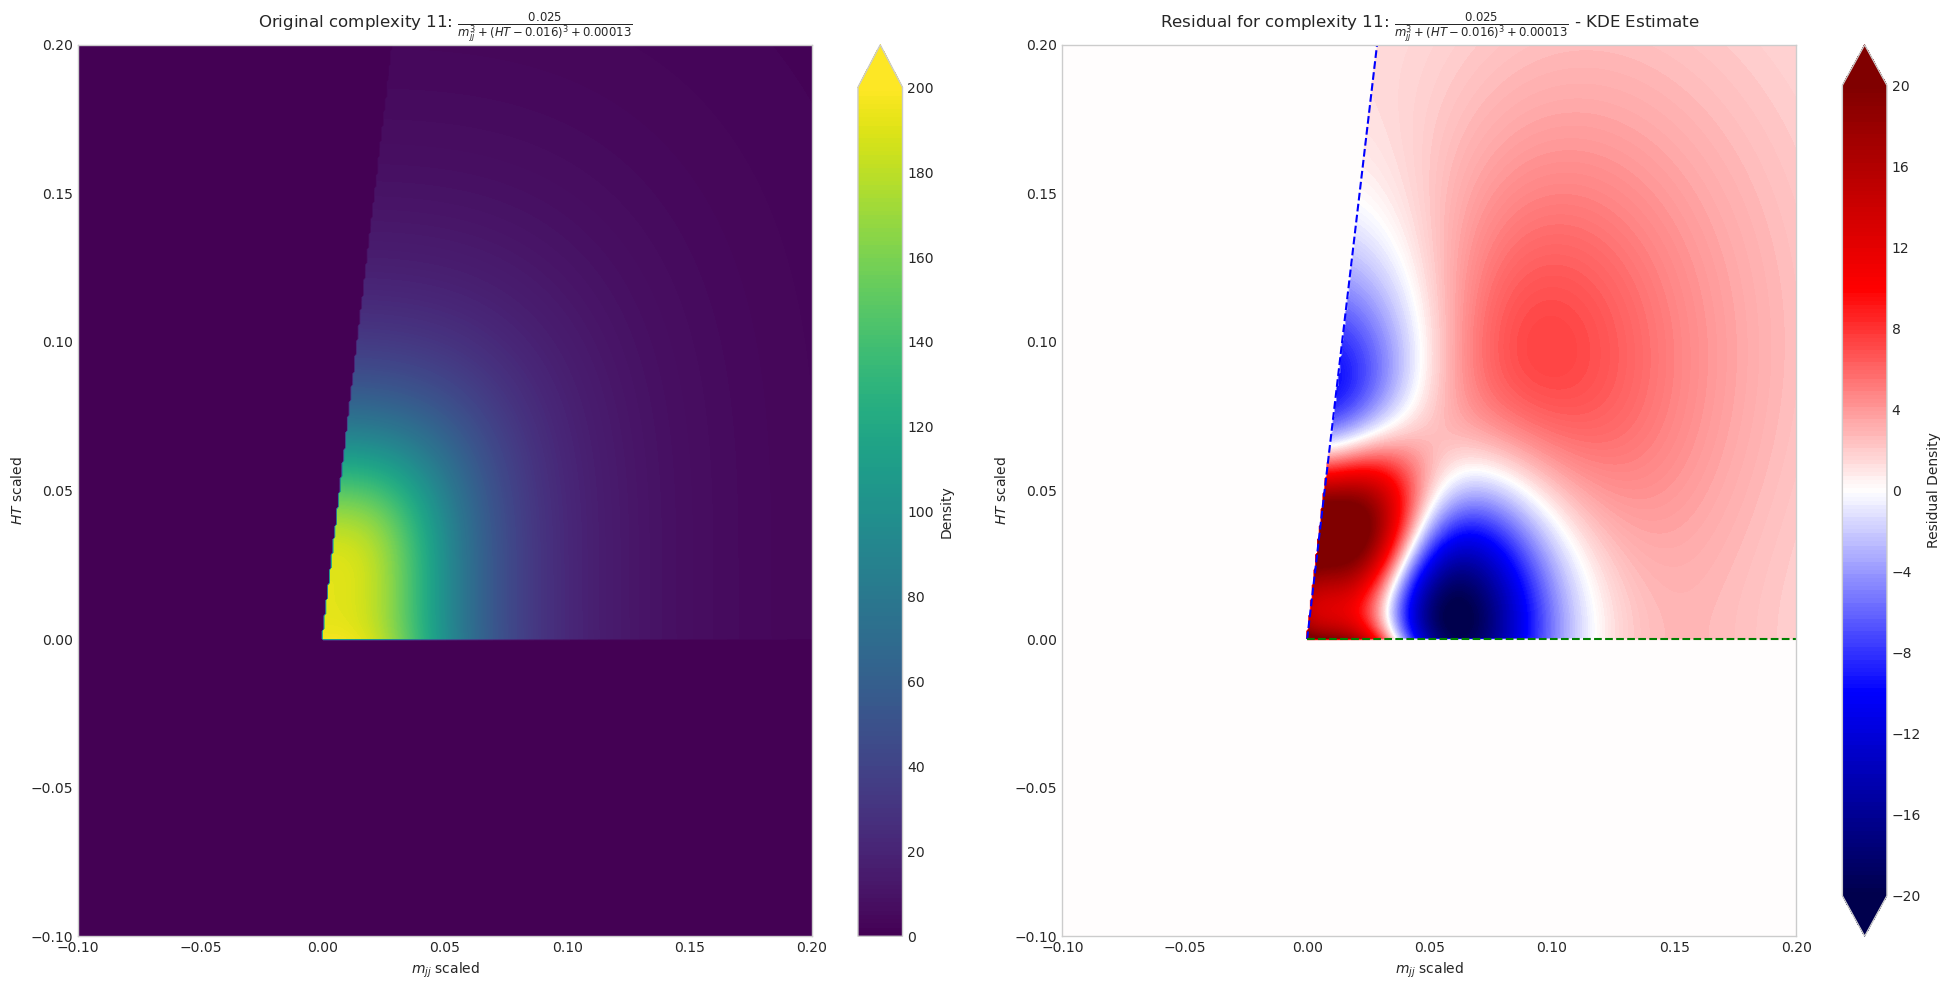

Complexity 11: Likelihood score: 484,340.1700184365
complexity 11 :: min predict: 0.00, max predict: 196.27
complexity 11 :: min residual: -20.60, max residual: 24.58


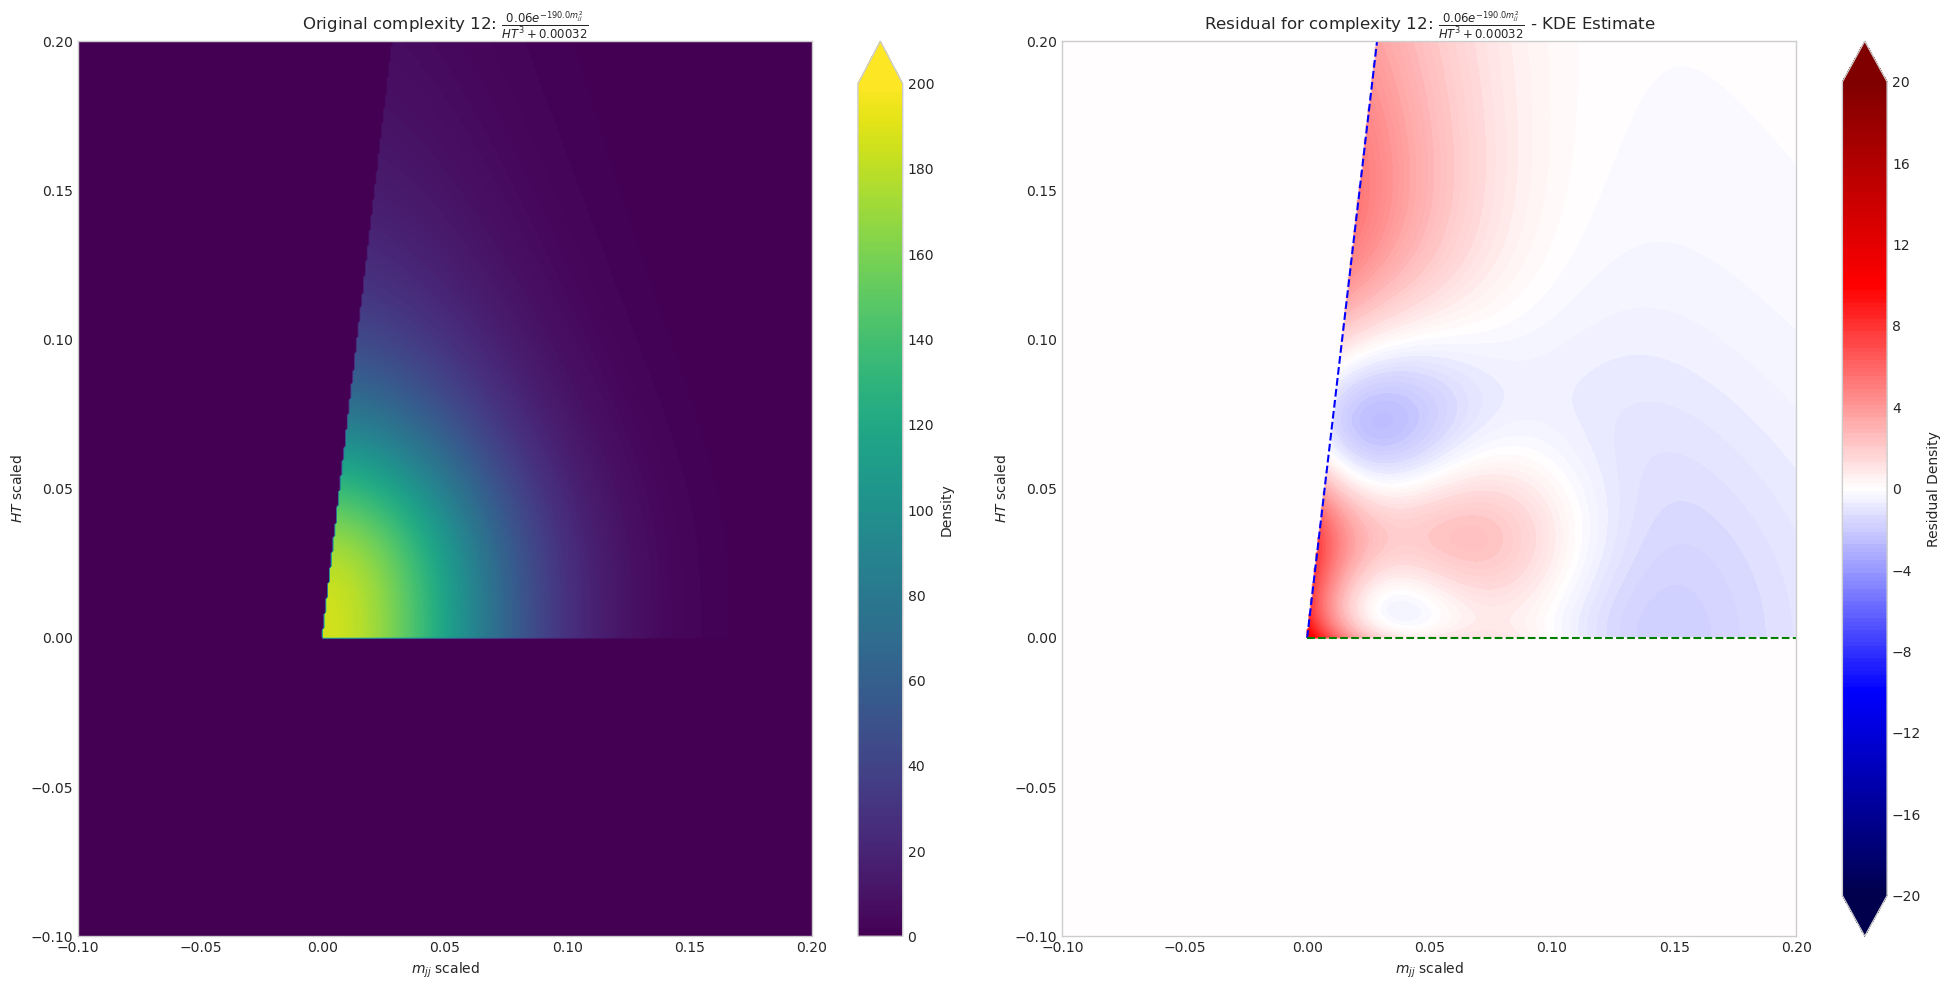

Complexity 12: Likelihood score: 471,622.88183657854
complexity 12 :: min predict: 0.00, max predict: 185.59
complexity 12 :: min residual: -2.57, max residual: 10.93


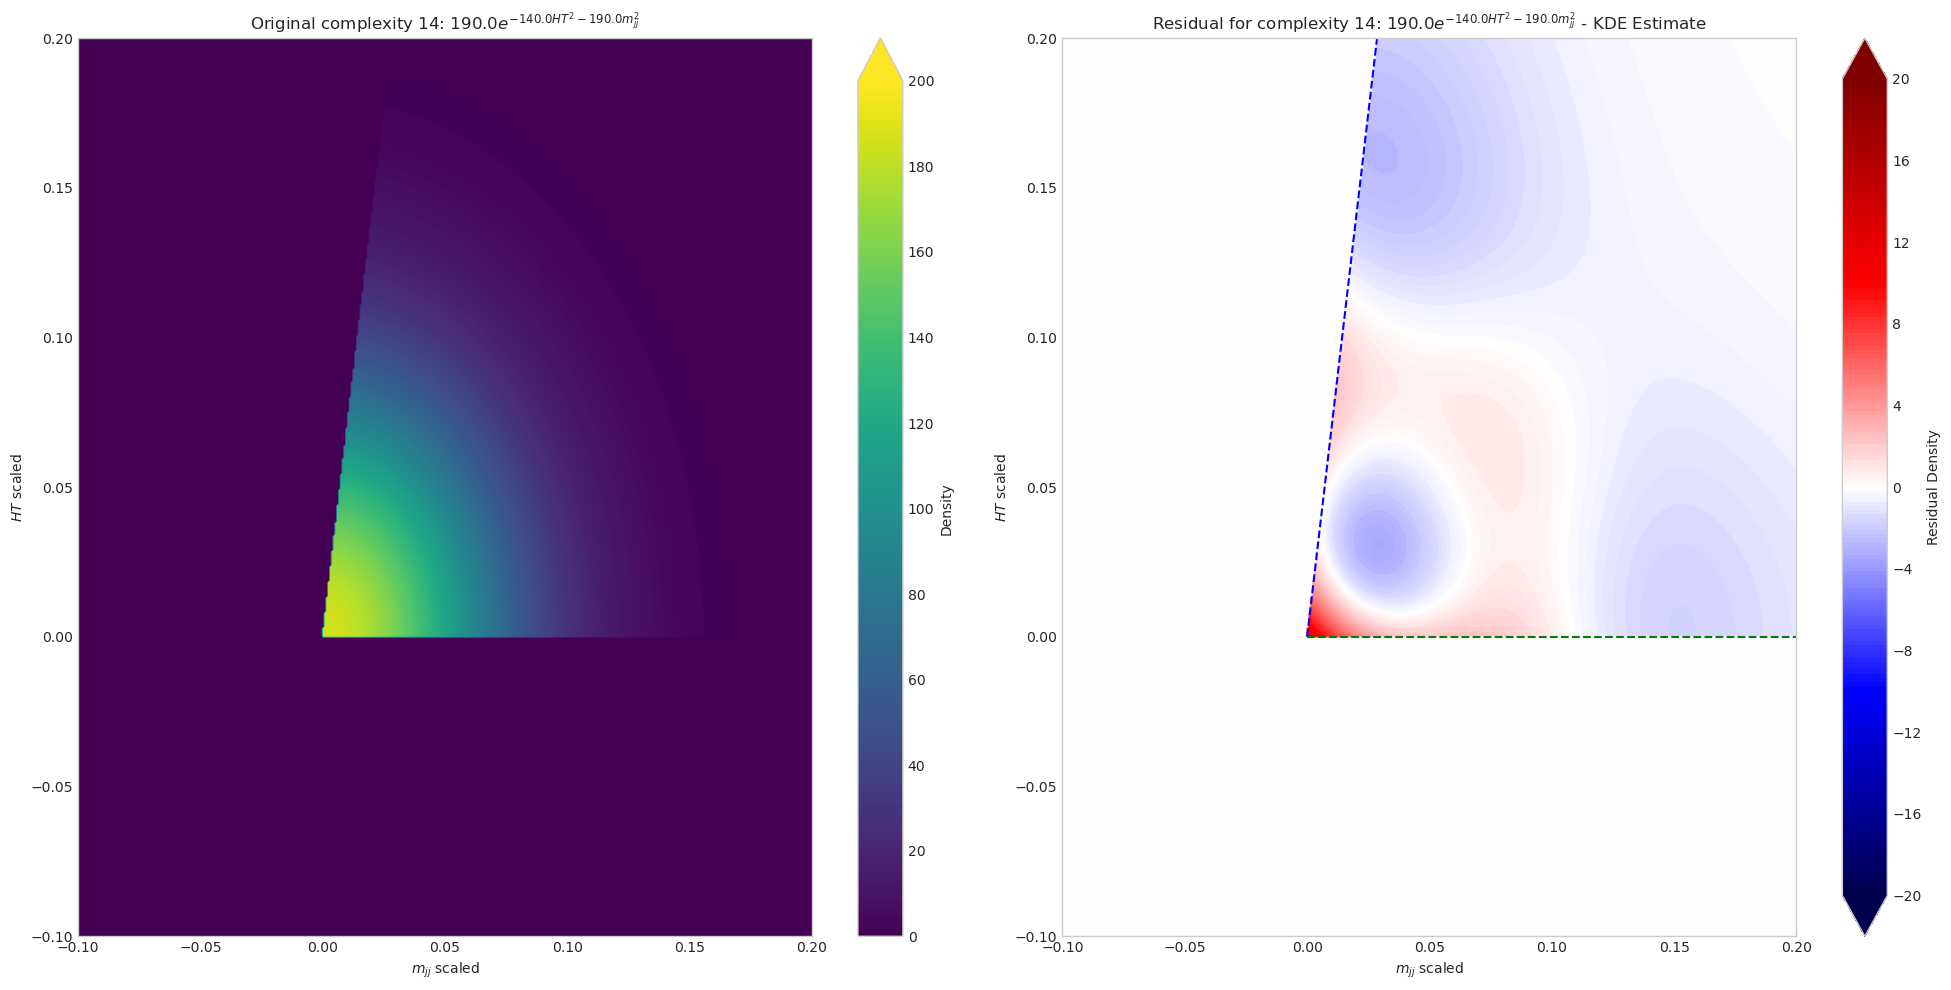

Complexity 14: Likelihood score: 463,254.3400169308
complexity 14 :: min predict: 0.00, max predict: 186.87
complexity 14 :: min residual: -3.35, max residual: 12.21


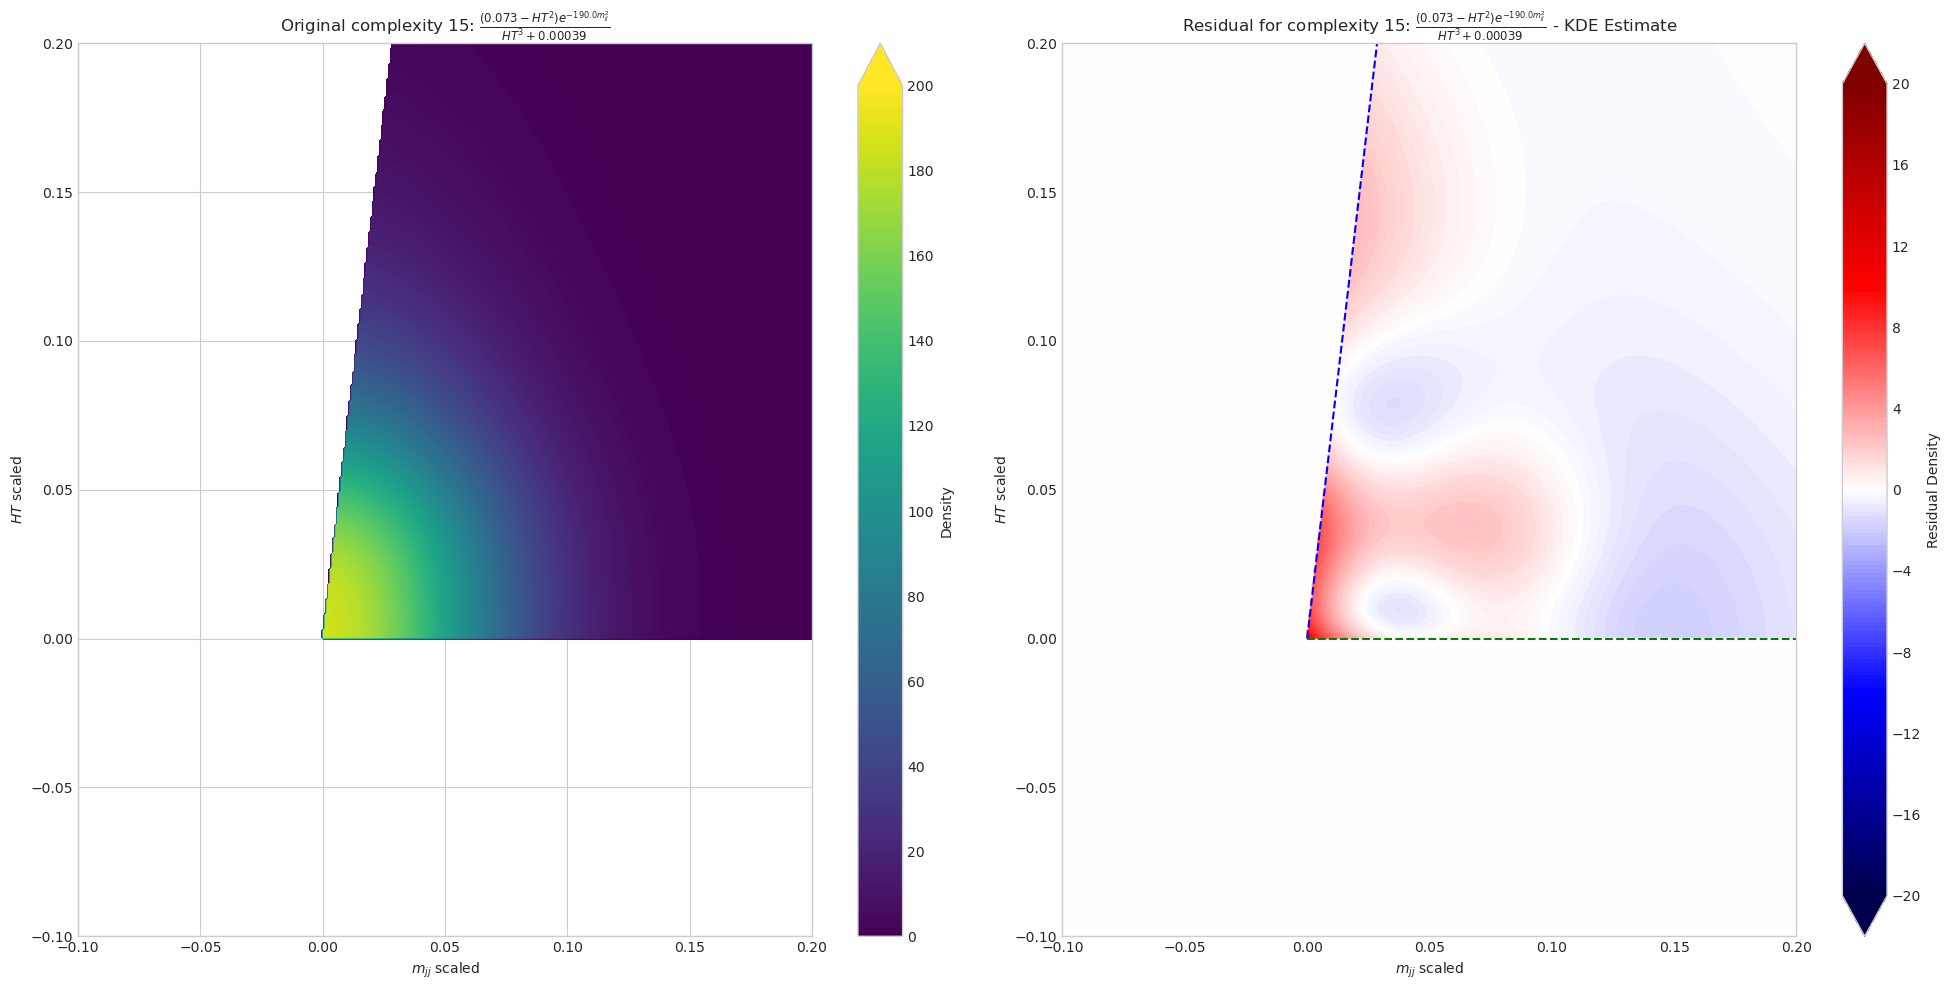

/tmp/ipykernel_2942/1043867983.py:76: RuntimeWarning: invalid value encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples))


Complexity 15: Likelihood score: nan
complexity 15 :: min predict: -0.74, max predict: 184.87
complexity 15 :: min residual: -1.86, max residual: 10.21


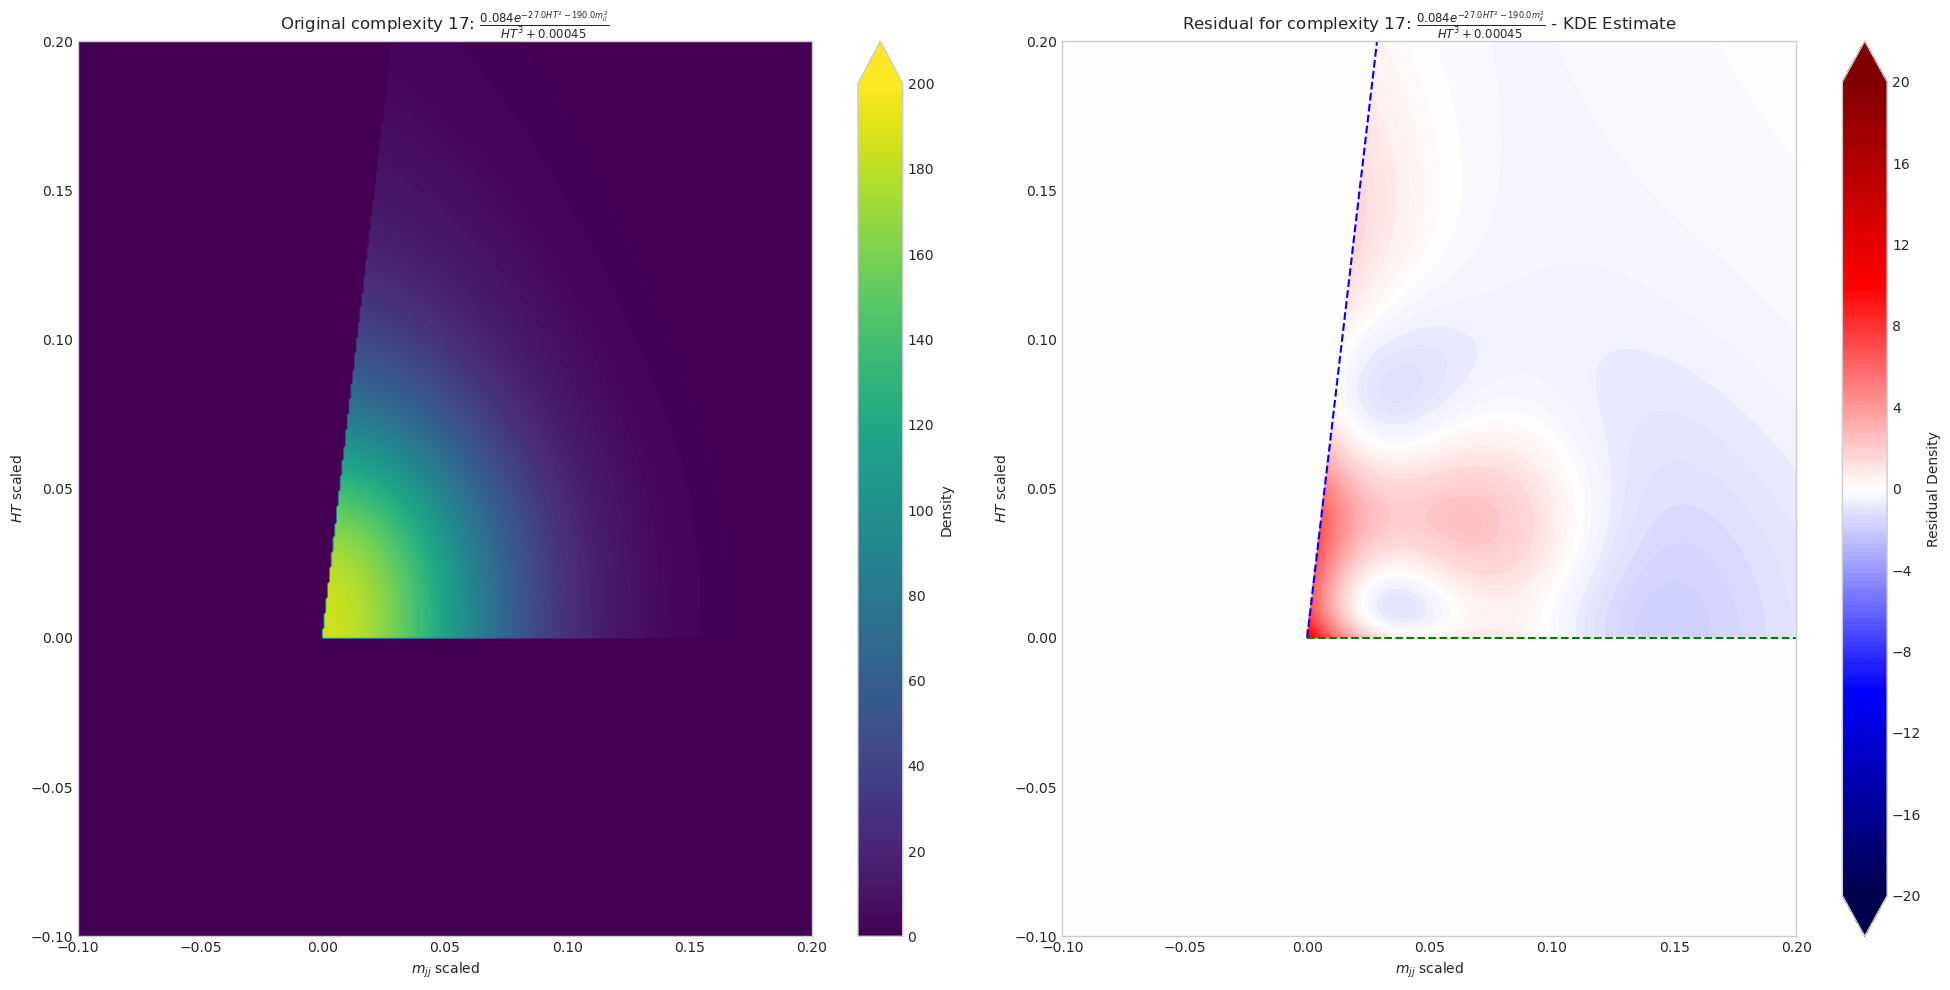

Complexity 17: Likelihood score: 469,369.50182211515
complexity 17 :: min predict: 0.00, max predict: 185.07
complexity 17 :: min residual: -1.86, max residual: 10.40


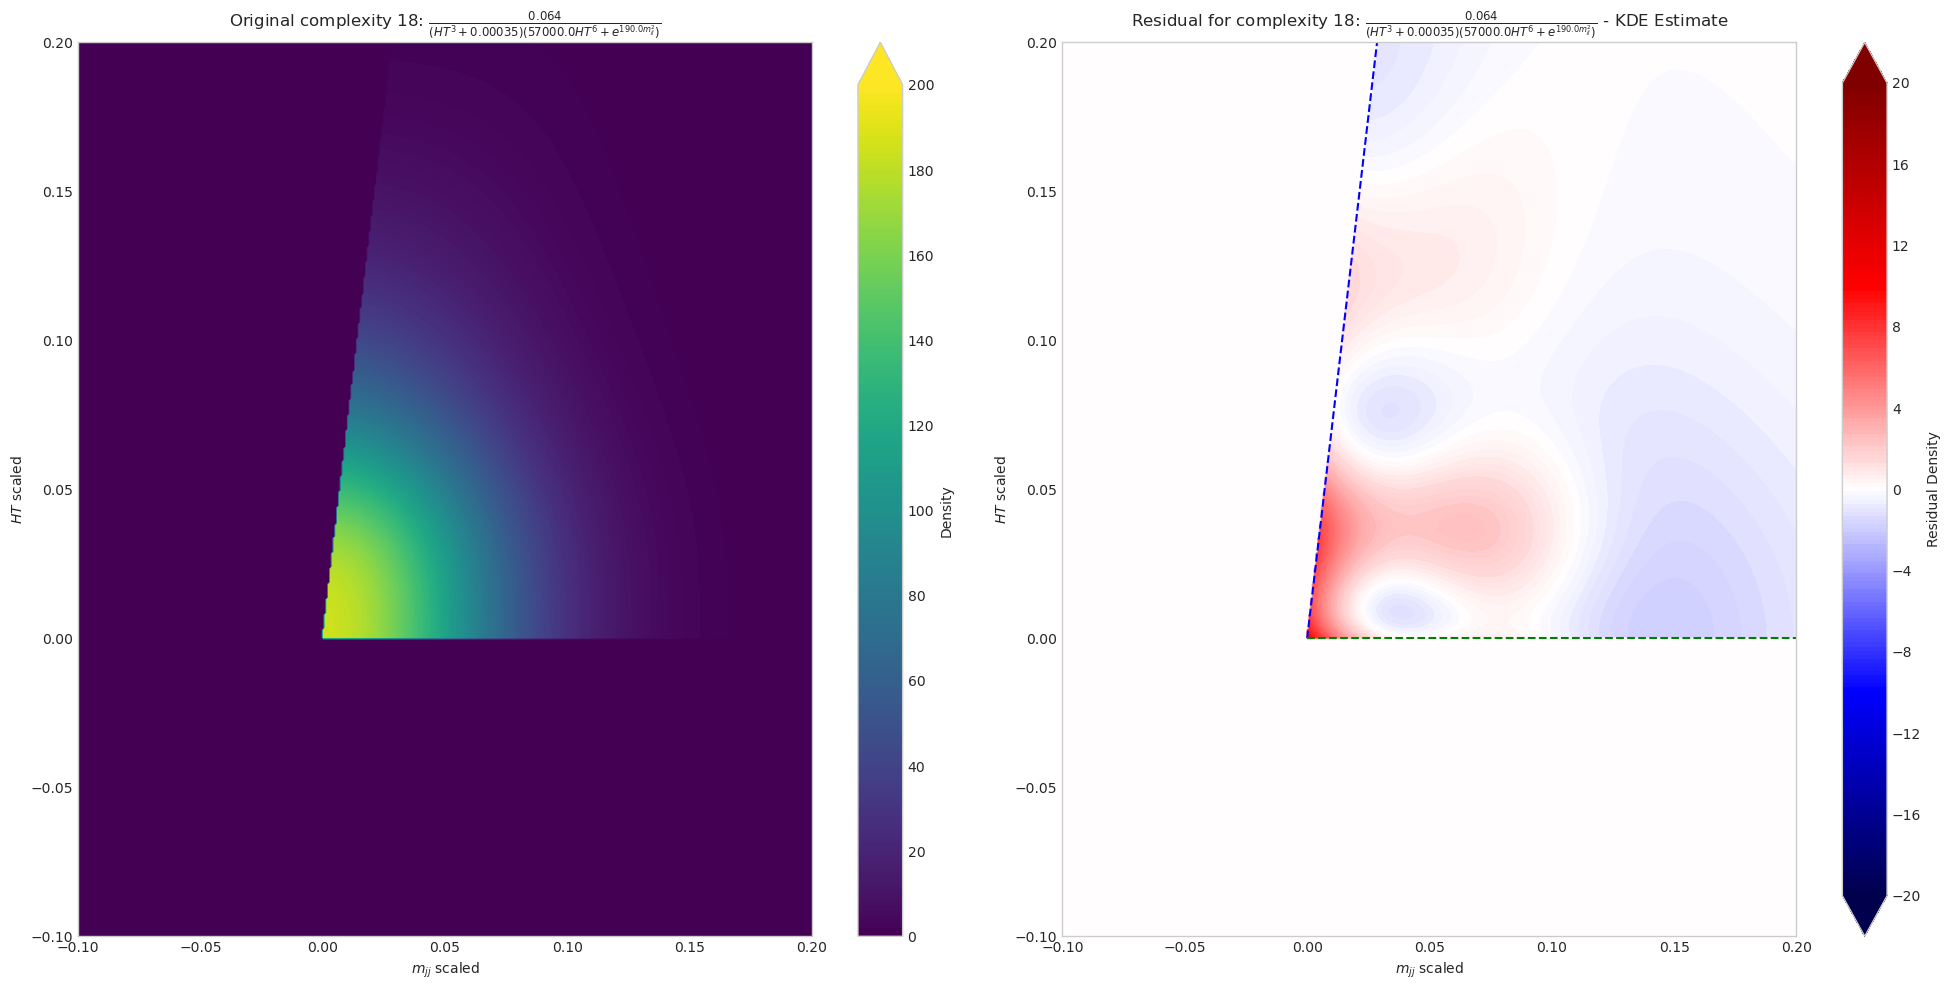

Complexity 18: Likelihood score: 469,230.61161093647
complexity 18 :: min predict: 0.00, max predict: 184.72
complexity 18 :: min residual: -1.90, max residual: 10.06


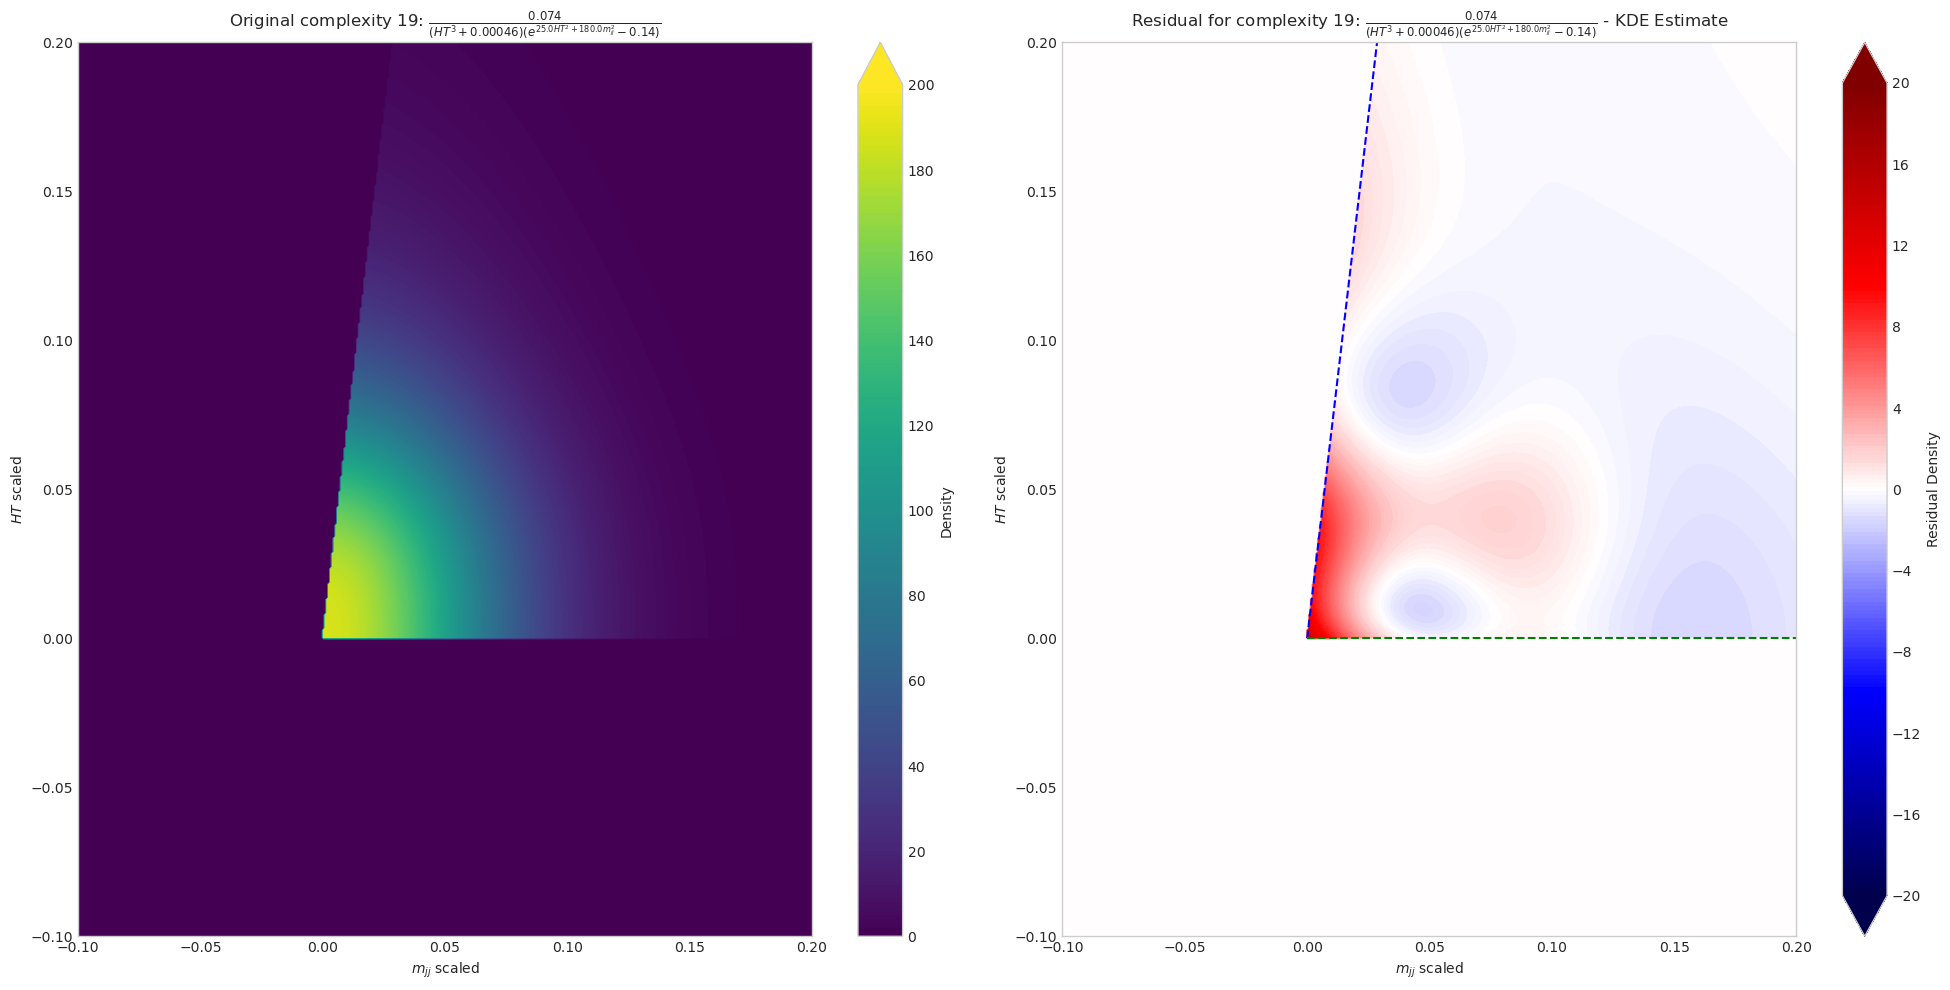

Complexity 19: Likelihood score: 471,281.64983624034
complexity 19 :: min predict: 0.00, max predict: 188.29
complexity 19 :: min residual: -1.58, max residual: 13.62


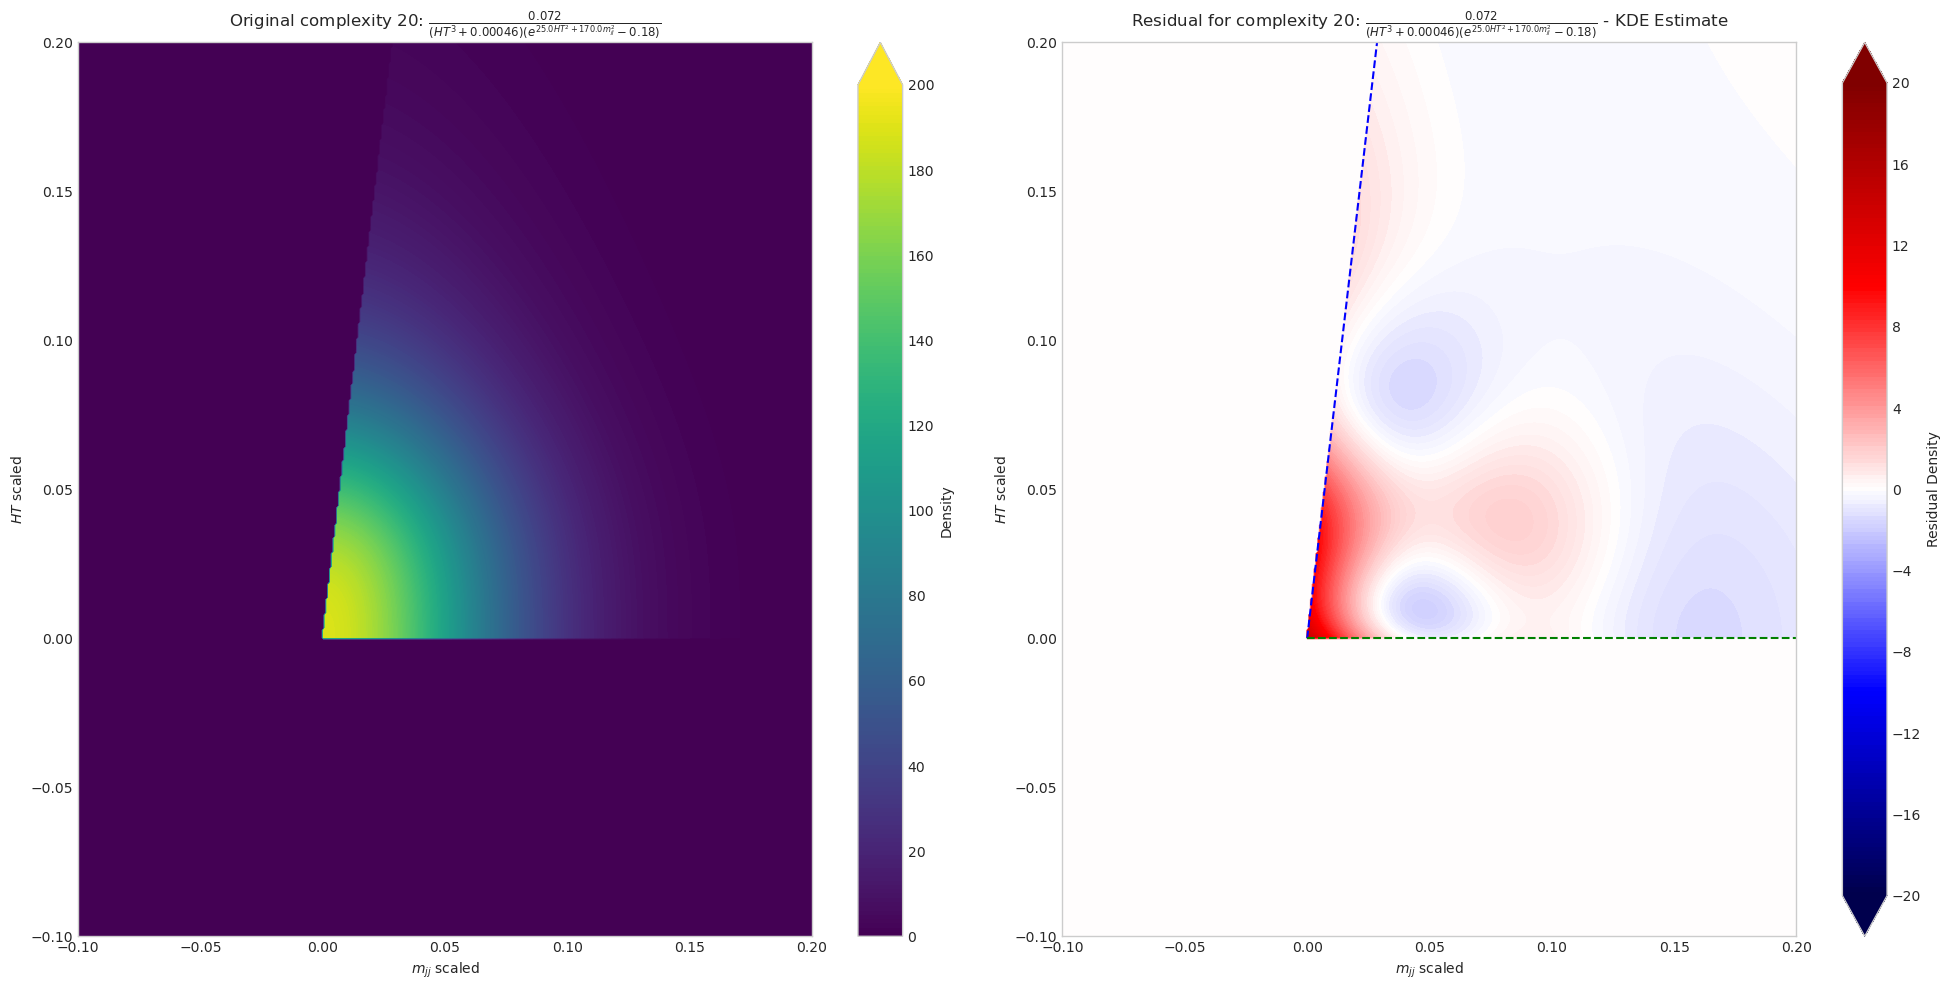

Complexity 20: Likelihood score: 471,743.82719984296
complexity 20 :: min predict: 0.00, max predict: 188.87
complexity 20 :: min residual: -1.84, max residual: 14.21


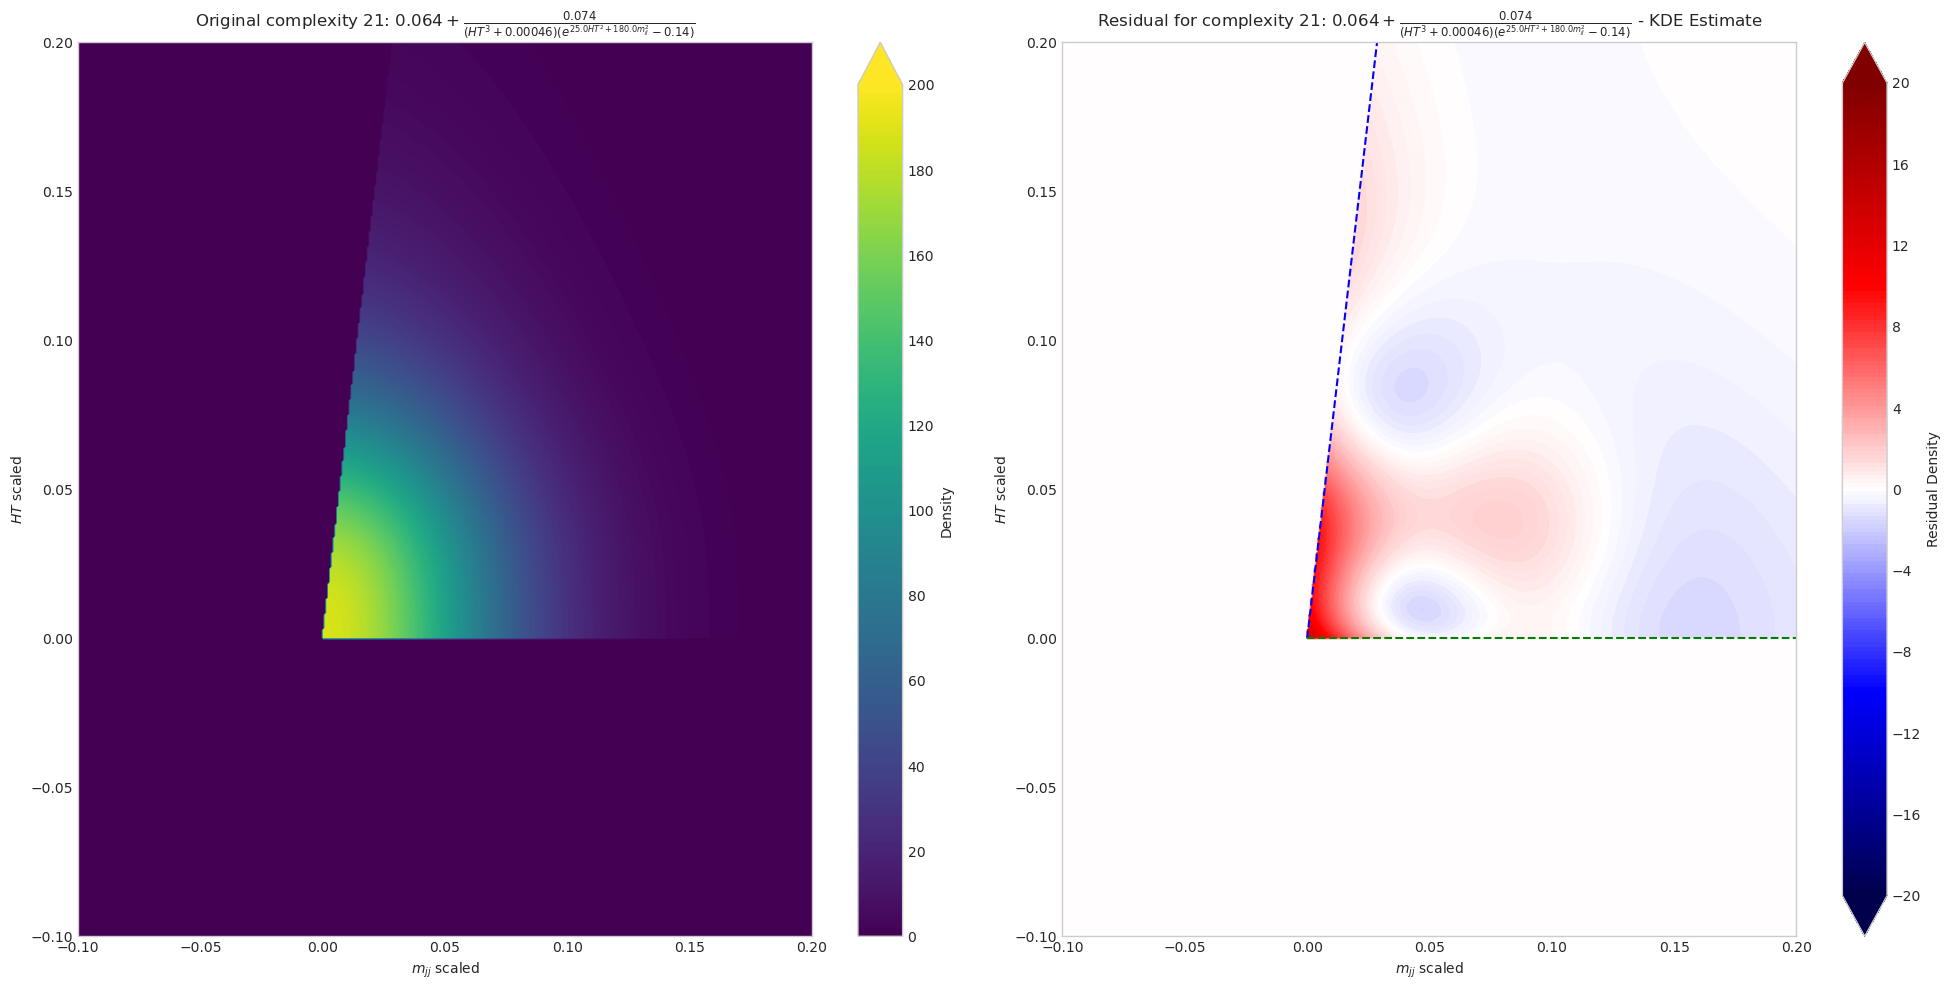

Complexity 21: Likelihood score: 477,836.3059980617
complexity 21 :: min predict: 0.00, max predict: 188.35
complexity 21 :: min residual: -1.52, max residual: 13.69


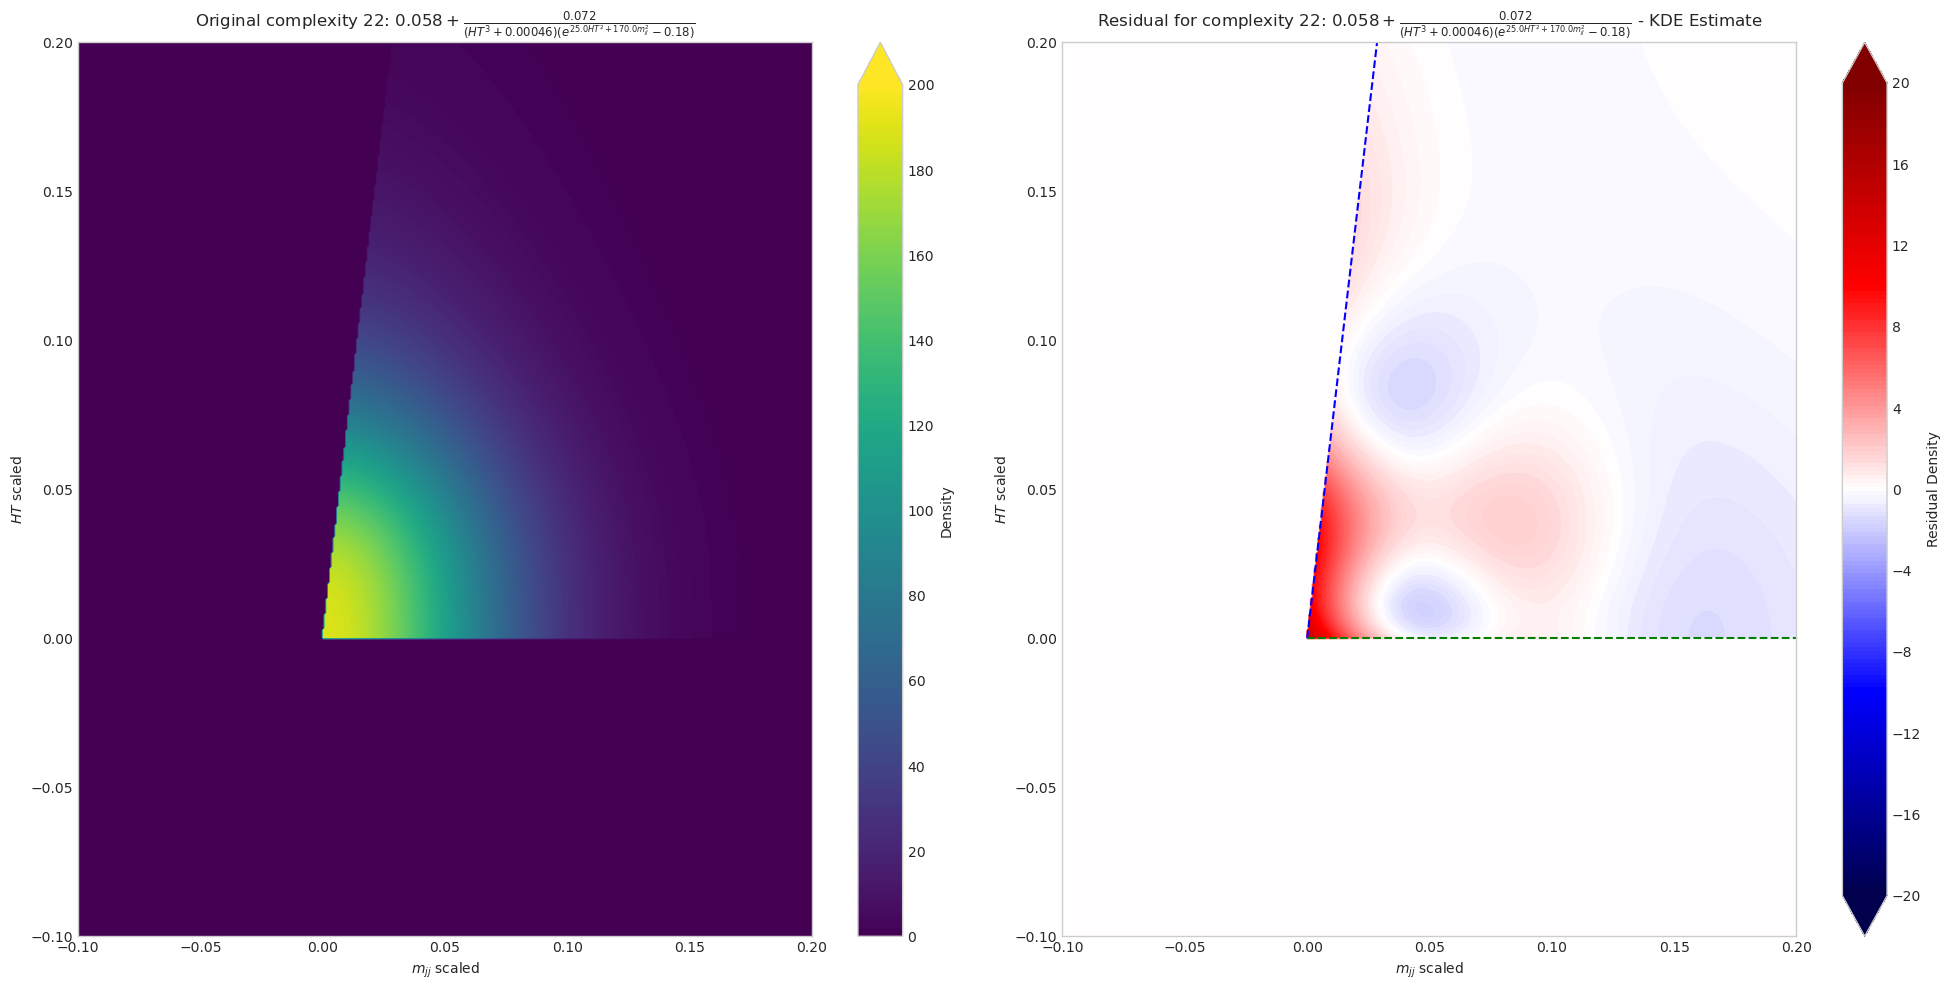

Complexity 22: Likelihood score: 477,970.82798048586
complexity 22 :: min predict: 0.00, max predict: 188.93
complexity 22 :: min residual: -1.79, max residual: 14.27


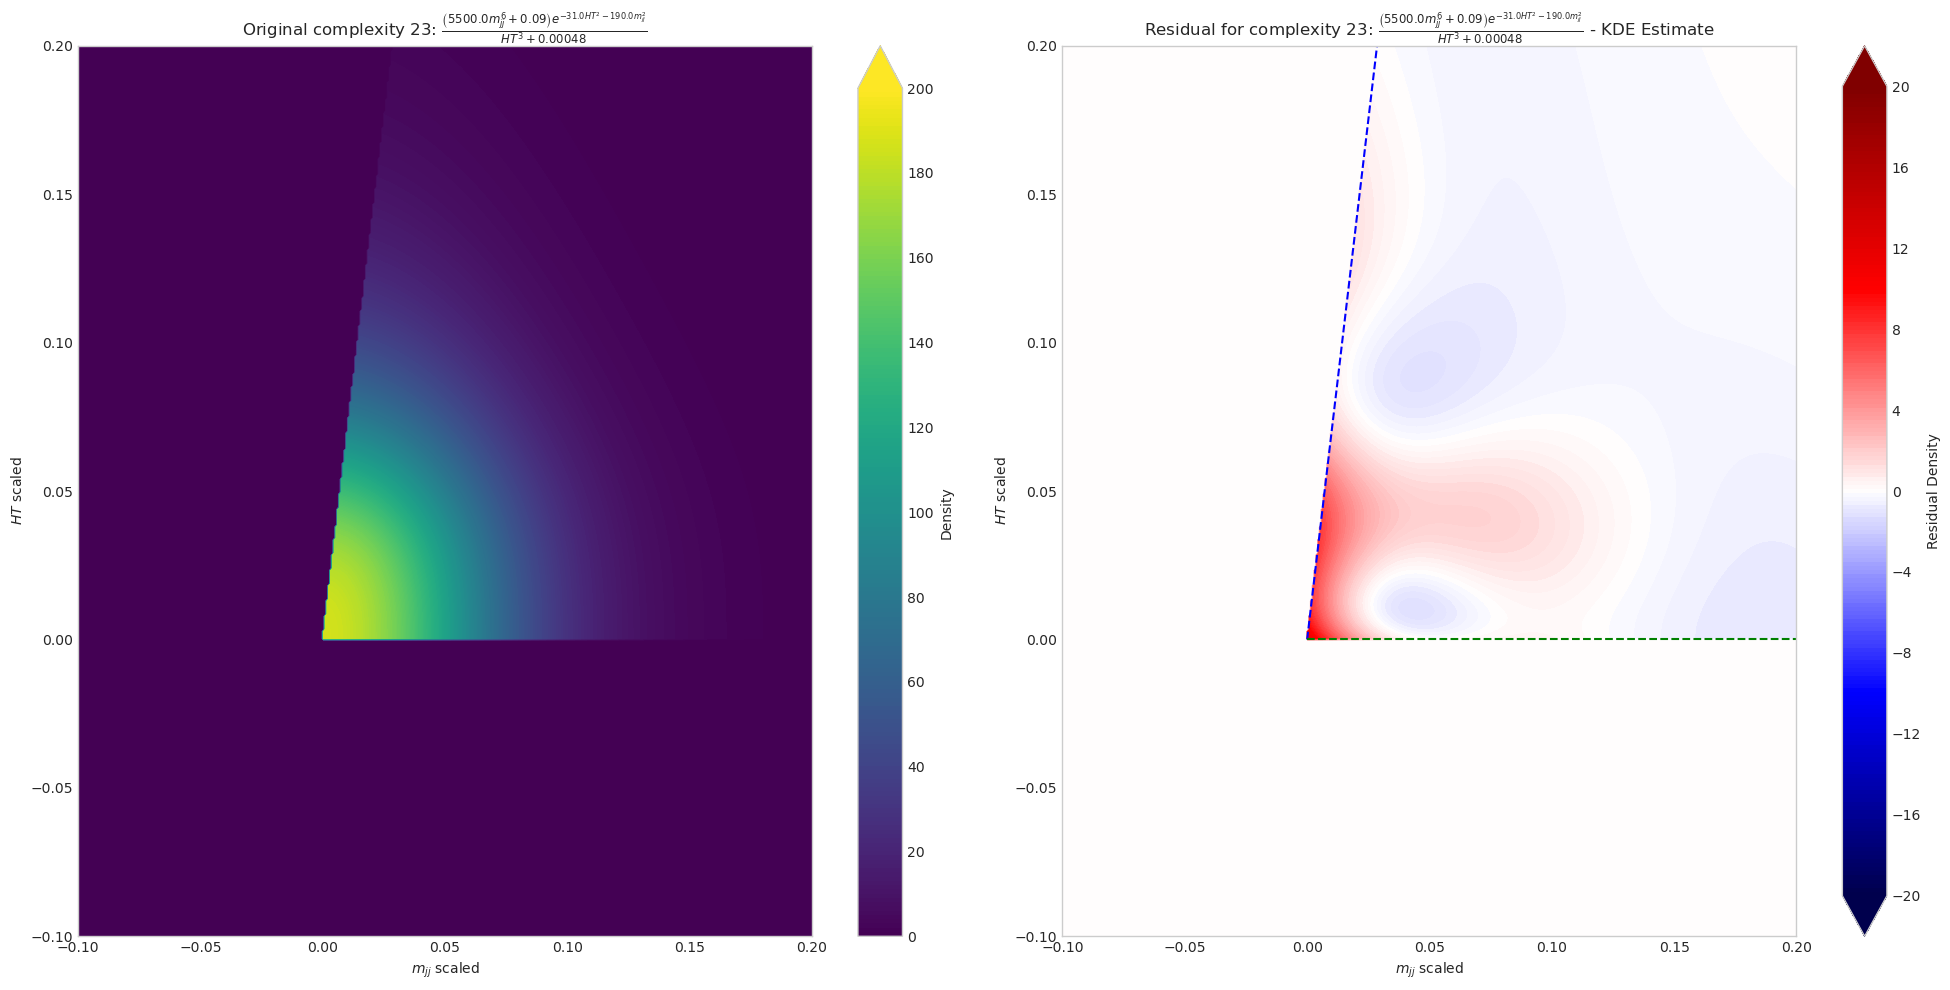

Complexity 23: Likelihood score: 471,683.5972434587
complexity 23 :: min predict: 0.00, max predict: 186.33
complexity 23 :: min residual: -1.27, max residual: 11.66


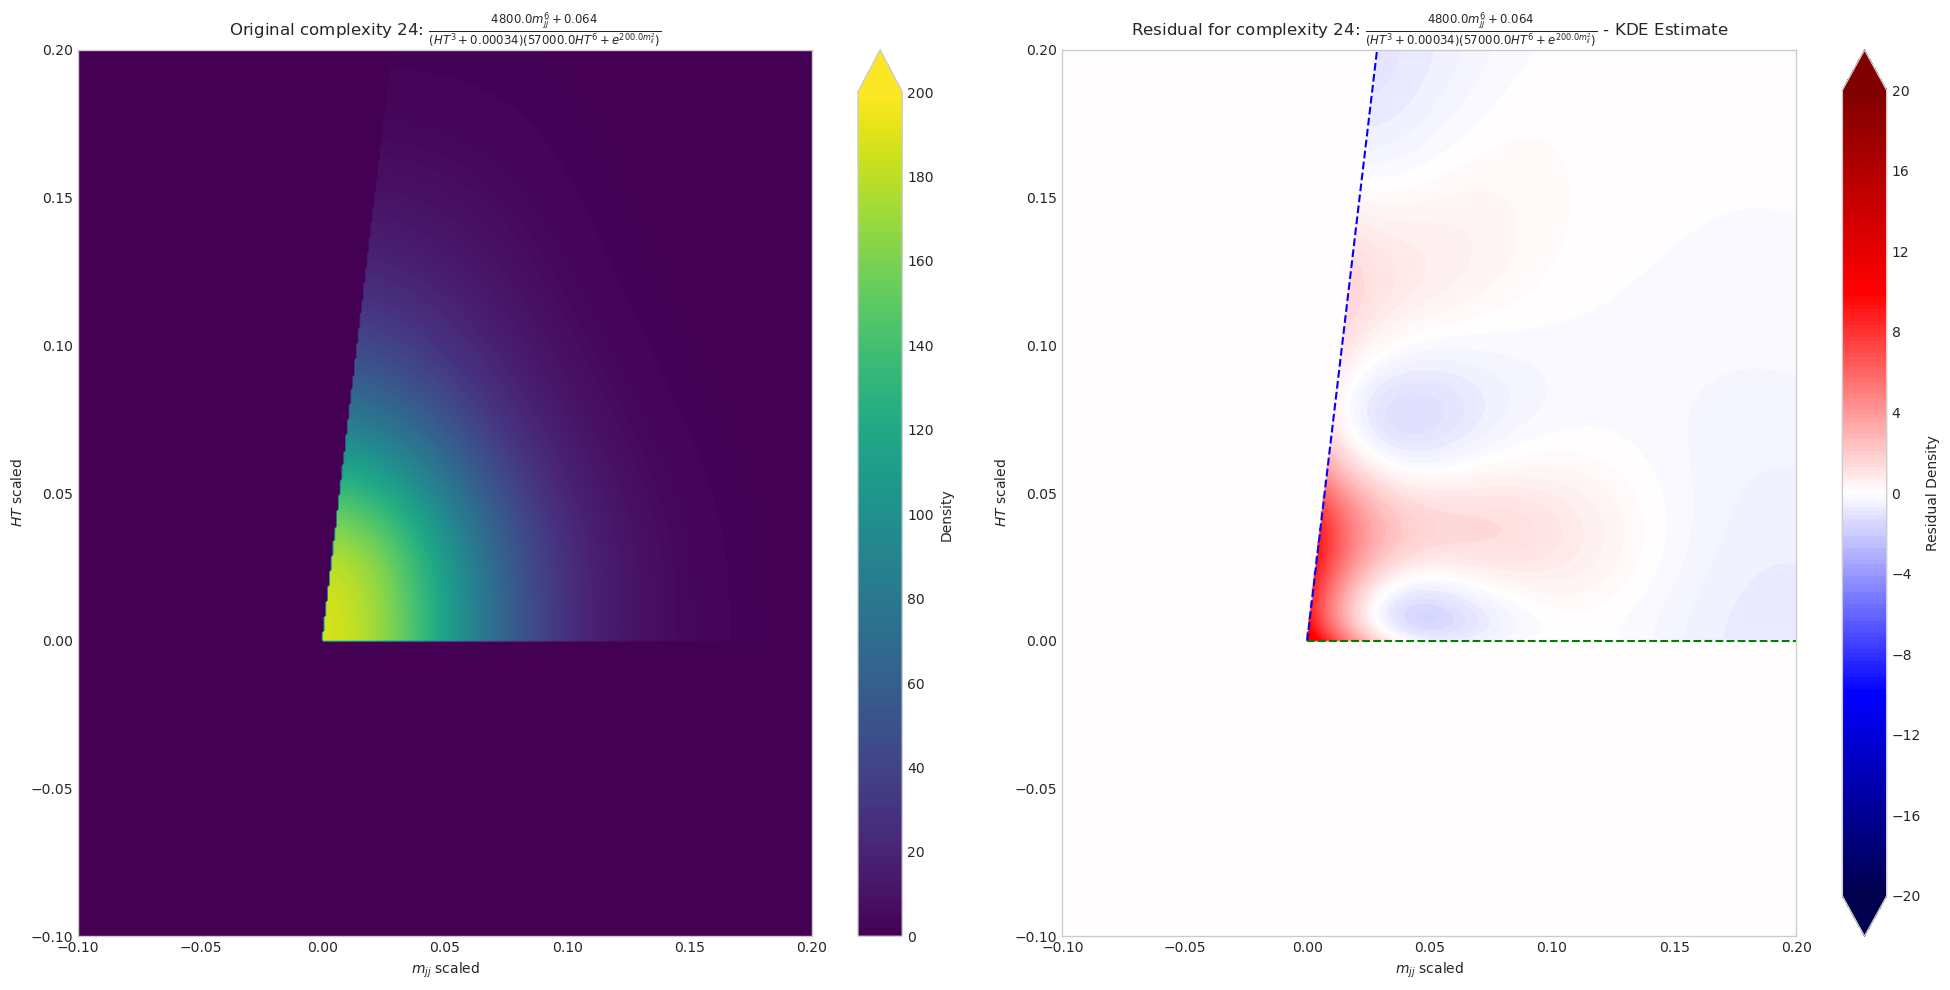

Complexity 24: Likelihood score: 472,107.6853868457
complexity 24 :: min predict: 0.00, max predict: 186.51
complexity 24 :: min residual: -1.56, max residual: 11.84


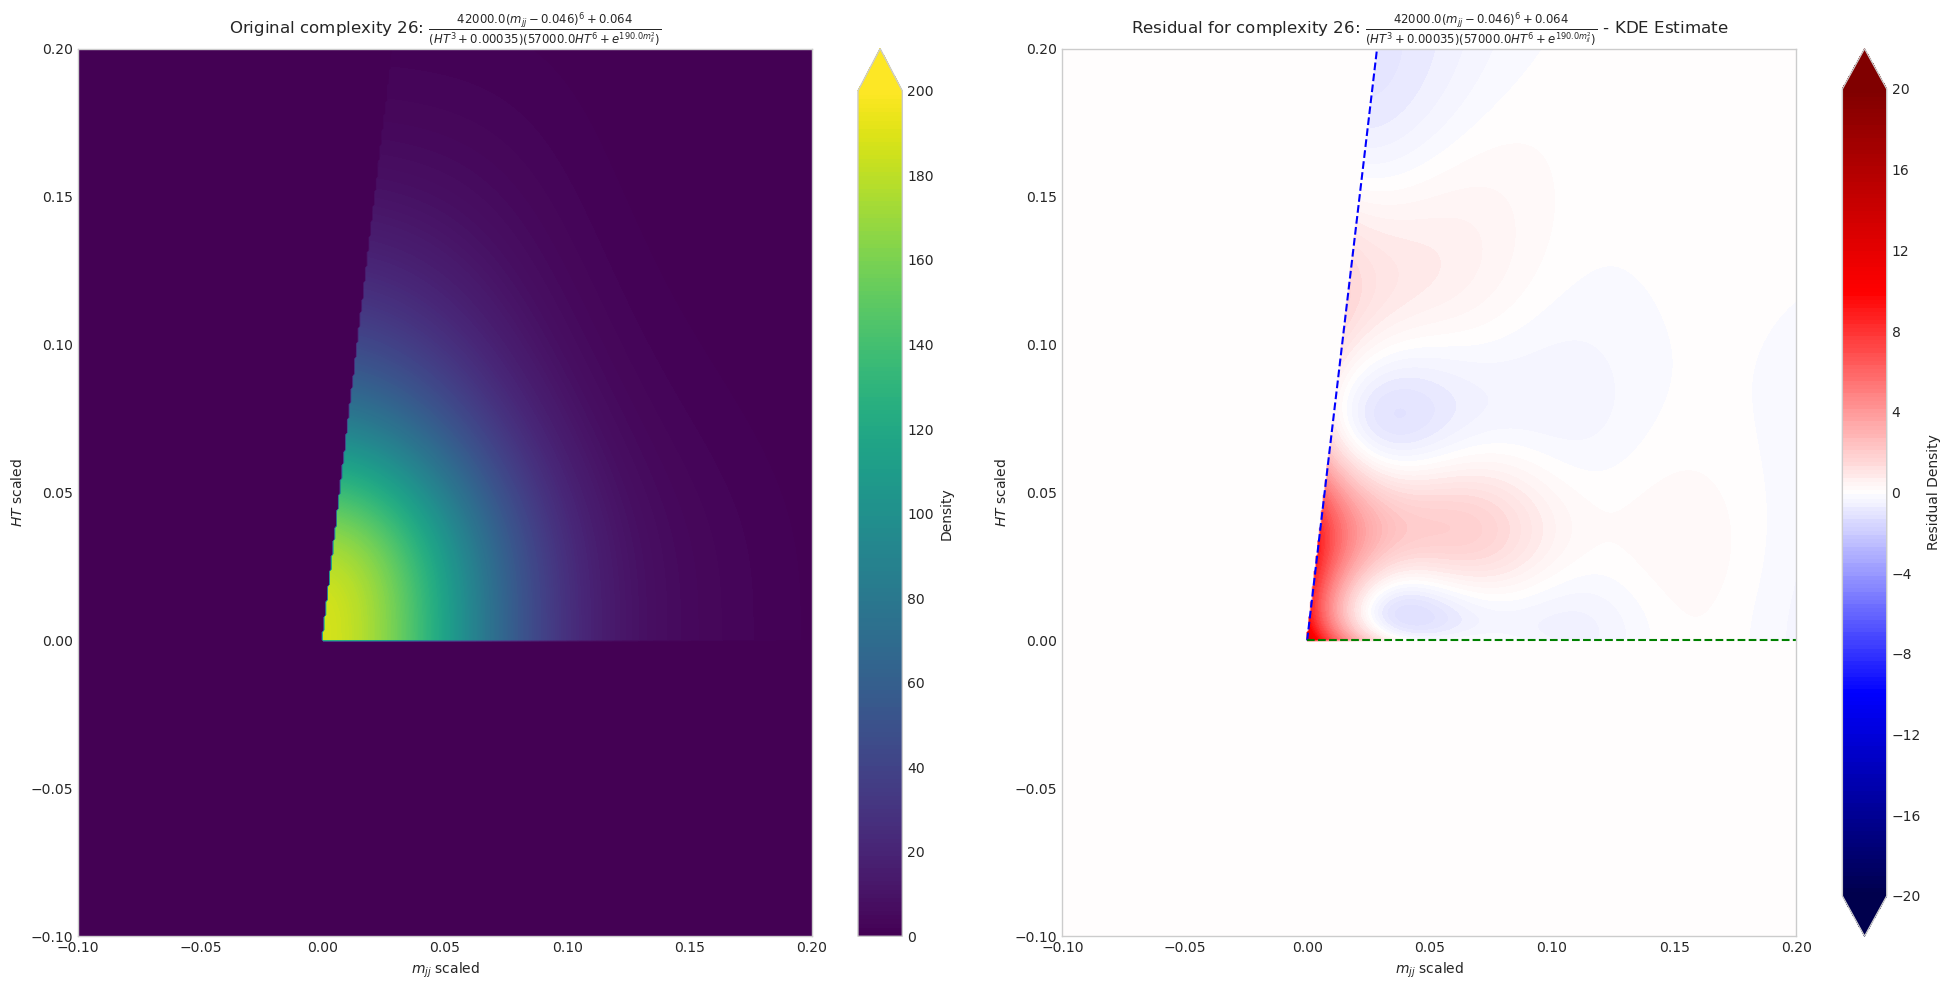

Complexity 26: Likelihood score: 472,943.85085271444
complexity 26 :: min predict: 0.00, max predict: 186.67
complexity 26 :: min residual: -1.30, max residual: 12.01


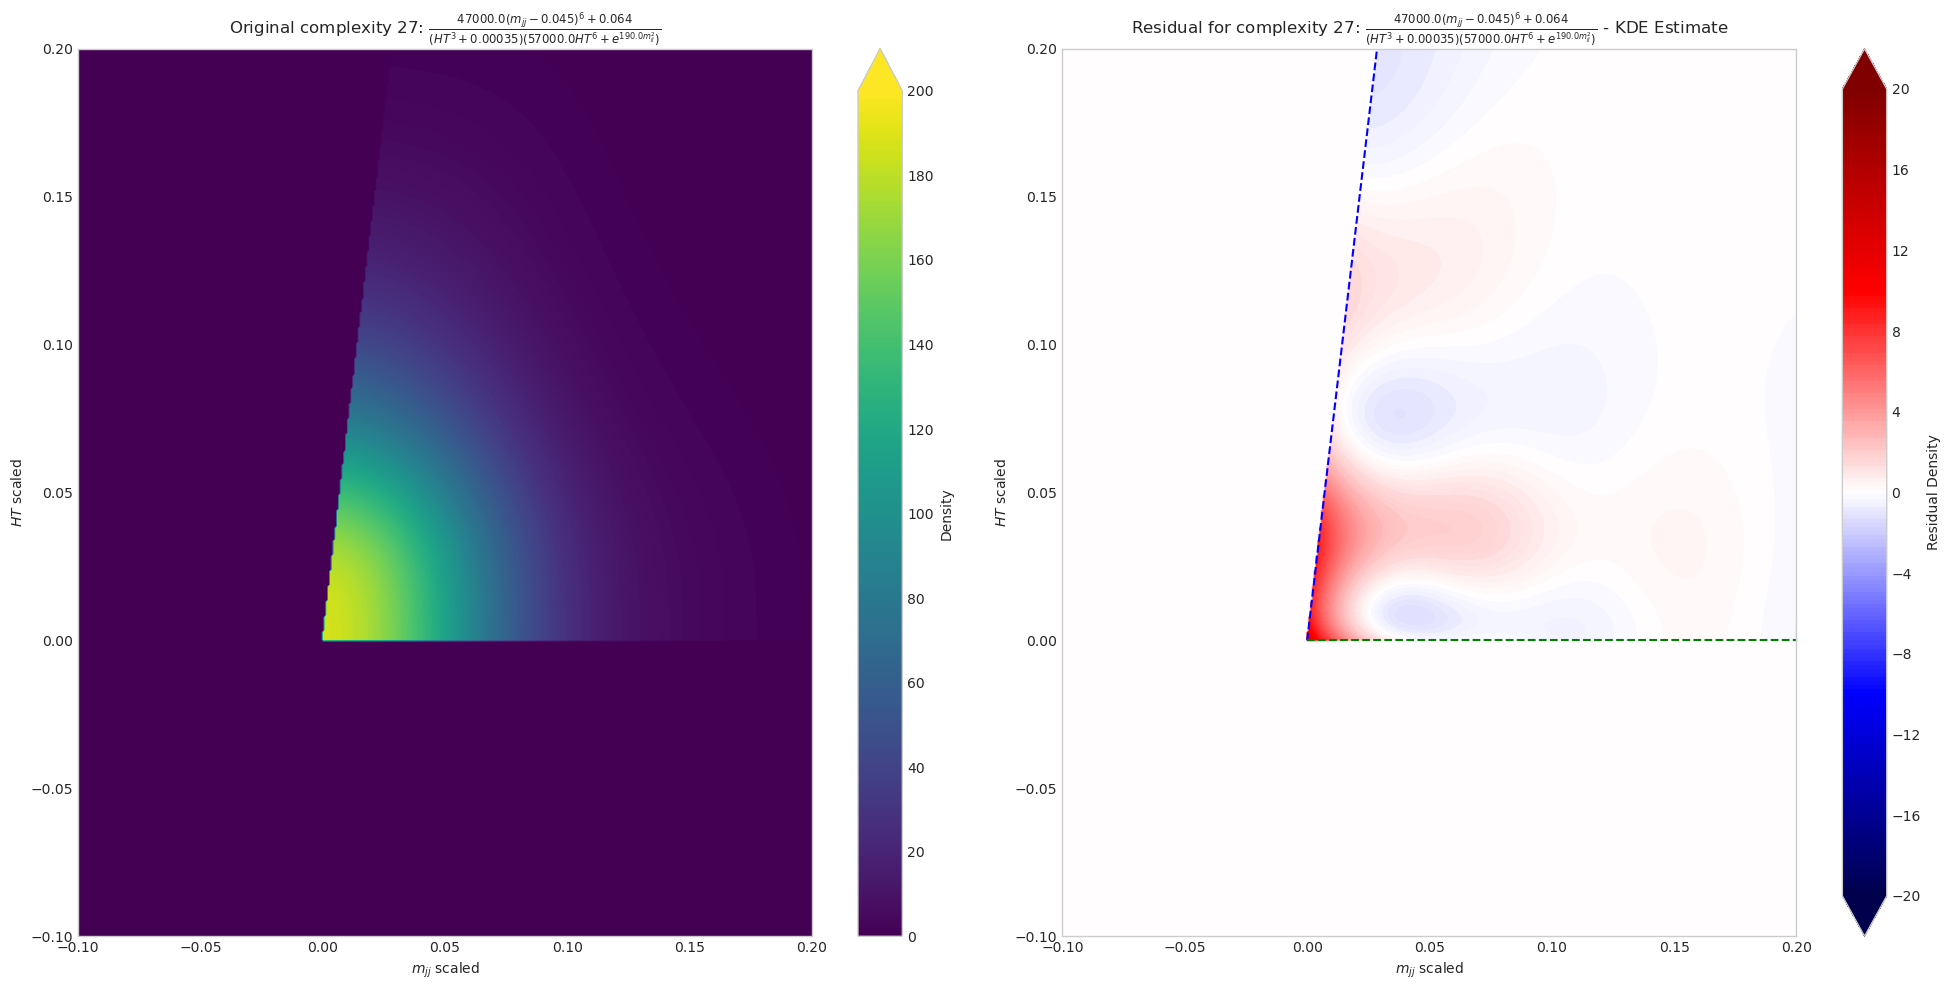

Complexity 27: Likelihood score: 472,999.81056887173
complexity 27 :: min predict: 0.00, max predict: 186.67
complexity 27 :: min residual: -1.30, max residual: 12.01


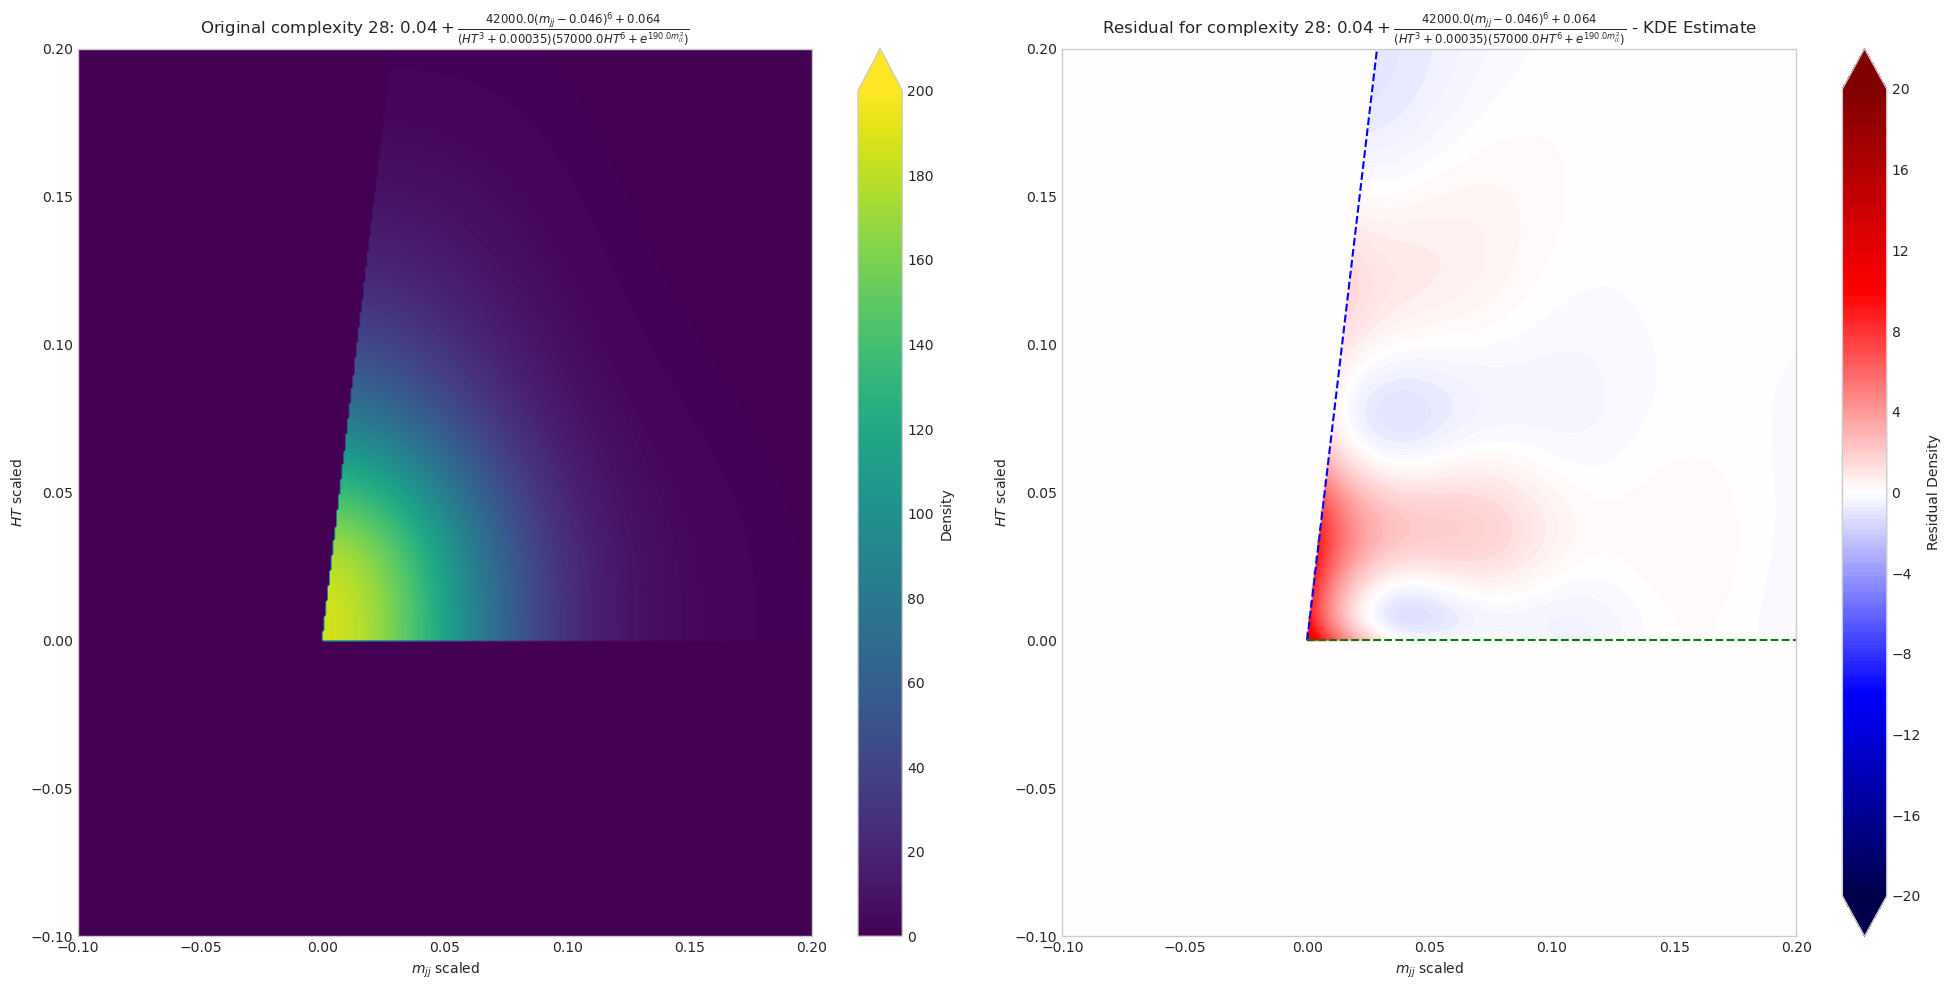

Complexity 28: Likelihood score: 477,405.86063119594
complexity 28 :: min predict: 0.00, max predict: 186.71
complexity 28 :: min residual: -1.26, max residual: 12.05


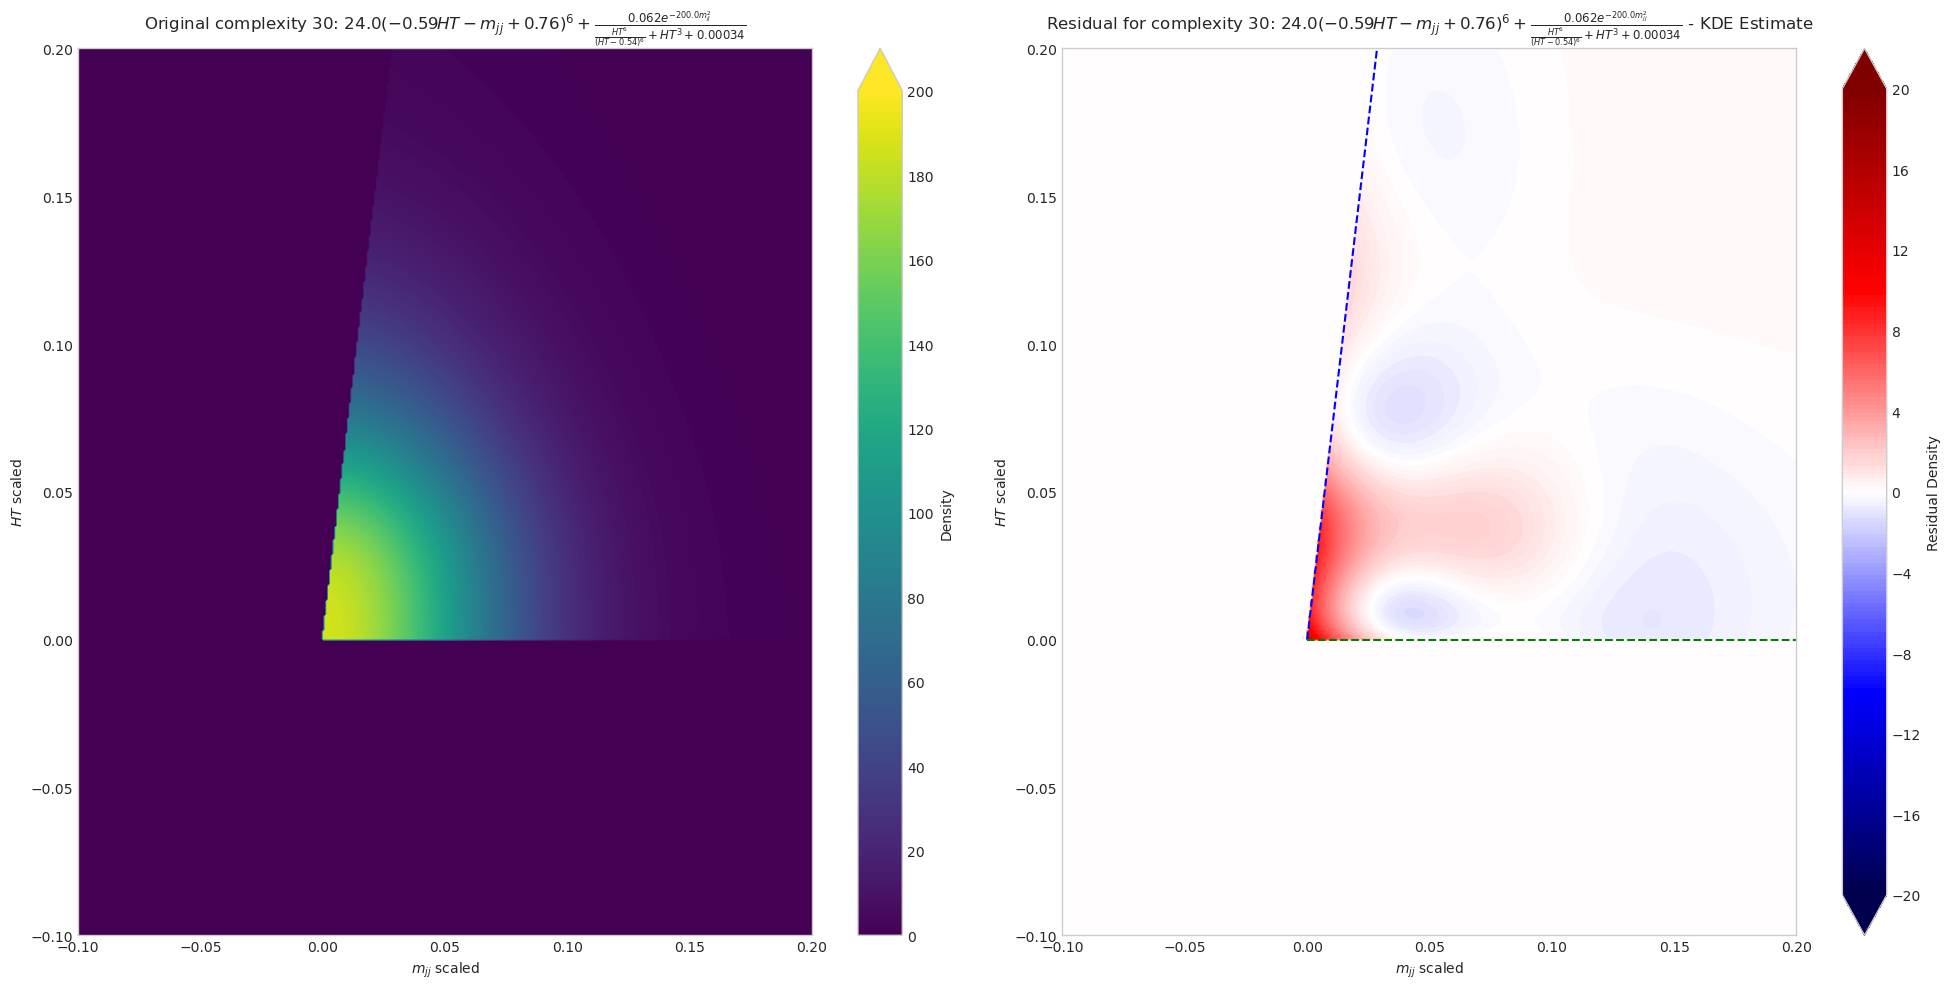

Complexity 30: Likelihood score: 478,227.23931810254
complexity 30 :: min predict: 0.00, max predict: 186.60
complexity 30 :: min residual: -1.37, max residual: 22.96
Finished generating and saving plots for 25 functions.


In [22]:
# Iterate over the masked_functions list
for i, current_function in enumerate(masked_functions):
    # Skip if the function is not defined or you only want to plot specific ones
    # if i not in [2, 5]:  # Example: plot only indices 2 and 5
    #     continue

    # Get the title for the current function
    title = latex_labels[i]

    # Create a new figure for each iteration
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # --- Plot 1: Original Function Plot (current_function) ---
    ax1 = axes[0]
    
    # Calculate the function output
    function_output = current_function(grids[0], grids[1], ~mask)
    
    # Set levels based on your required range
    levels_original = np.linspace(level_min, level_max, 200)
    
    contour1 = ax1.contourf(
        grids[0], grids[1],
        function_output,
        levels=levels_original,
        cmap='viridis',
        extend='max'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour1, ax=ax1, label="Density", ticks=np.linspace(level_min, level_max, 11))
    
    ax1.set_xlabel(r"$m_{jj}$ scaled")
    ax1.set_ylabel(r"$HT$ scaled")
    ax1.set_title(f"Original complexity {complexity[i]}: {title}")
    ax1.set_xlim(-0.1, 0.2)
    ax1.set_ylim(-0.1, 0.2)

    # --- Plot 2: Residual Plot (current_function - sum_grid) ---
    ax2 = axes[1]
    
    # Calculate the residual
    residual_output = function_output - sum_grid
    
    # Set levels for the residual plot (should be symmetric around zero)
    levels_residual = np.linspace(level_min_delta, level_max_delta, 200)
    
    contour2 = ax2.contourf(
        grids[0], grids[1],
        residual_output,
        levels=levels_residual,
        cmap='seismic', # 'seismic' is good for residuals (zero in the middle)
        extend='both'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour2, ax=ax2, label="Residual Density", ticks=np.linspace(level_min_delta, level_max_delta, 11))
    
    ax2.set_xlabel(r"$m_{jj}$ scaled")
    ax2.set_ylabel(r"$HT$ scaled")
    ax2.set_title(f"Residual for complexity {complexity[i]}: {title} - KDE Estimate")
    ax2.plot(xlv, ylv, color='blue', linestyle='--', label='y=x Line')
    ax2.plot(xlh, ylh, color='green', linestyle='--', label='y=0 Line')
    ax2.set_xlim(-0.1, 0.2)
    ax2.set_ylim(-0.1, 0.2)

    # Final adjustments and saving
    plt.tight_layout()
    
    # *** KEY CHANGE: Display the plot inline ***
    plt.show()
    # 2. Explicitly close the figure object
    plt.close(fig) 
    
    # 3. Force the Python garbage collector to clean up memory
    gc.collect()
    prediction_eval_at_samples = current_function(scaled_samples[:,0], scaled_samples[:,1], np.ones_like(scaled_samples[:,0], dtype=bool))
    likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples))
    print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
    print(f"complexity {complexity[i]} :: min predict: {np.min(current_function(grids[0], grids[1], ~mask)):.2f}, max predict: {np.max(current_function(grids[0], grids[1], ~mask)):.2f}")
    min_residual = np.min(current_function(grids[0], grids[1], ~mask) - sum_grid)
    max_residual = np.max(current_function(grids[0], grids[1], ~mask) - sum_grid)
    print(f"complexity {complexity[i]} :: min residual: {min_residual:.2f}, max residual: {max_residual:.2f}")

# Note: plt.show() is typically outside the loop if you want to see all plots
# or not used at all if you are just saving the files.
print(f"Finished generating and saving plots for {len(masked_functions)} functions.")